--- Original Directed Graph Summary ---
EpiModelGraph(name='COVID-19_Spain_Treatment', compartments=['A', 'E', 'I', 'Q', 'R', 'S'] (6), params_nodes=0, exterior_nodes=1, interactions=20, other_expression_nodes=47)\nNote: Other expression nodes include Operations (O:), Functions (F:), Unknowns (U:), and Constants (K:). Pow uses 'base'/'exponent' edges. State variable dependencies use 'state_dependency' edges. Integrals use 'integrand', 'integration_variable', 'lower_limit', 'upper_limit' edges.
Number of nodes: 54
Number of edges: 95


--- Undirected Levi Graph Summary ---
Name: undirected_levi_COVID-19_Spain_Treatment
Number of nodes: 149
Number of edges: 190

Example nodes in Levi graph:
  Orig Node ID: C_R_1, Role: NodeRole.COMPARTMENT, Label: C:R
  Orig Node ID: C_Q_2, Role: NodeRole.COMPARTMENT, Label: C:Q
  EP Node ID: EP_edgeXEXTER_54, Label: EP:kind:flow;type:interaction_start, Orig Src: X_EXTERIOR_0, Orig Tgt: E_Lambda_7
  EP Node ID: EP_edgeCR1toO_55, Label: EP:kind:flow;type:

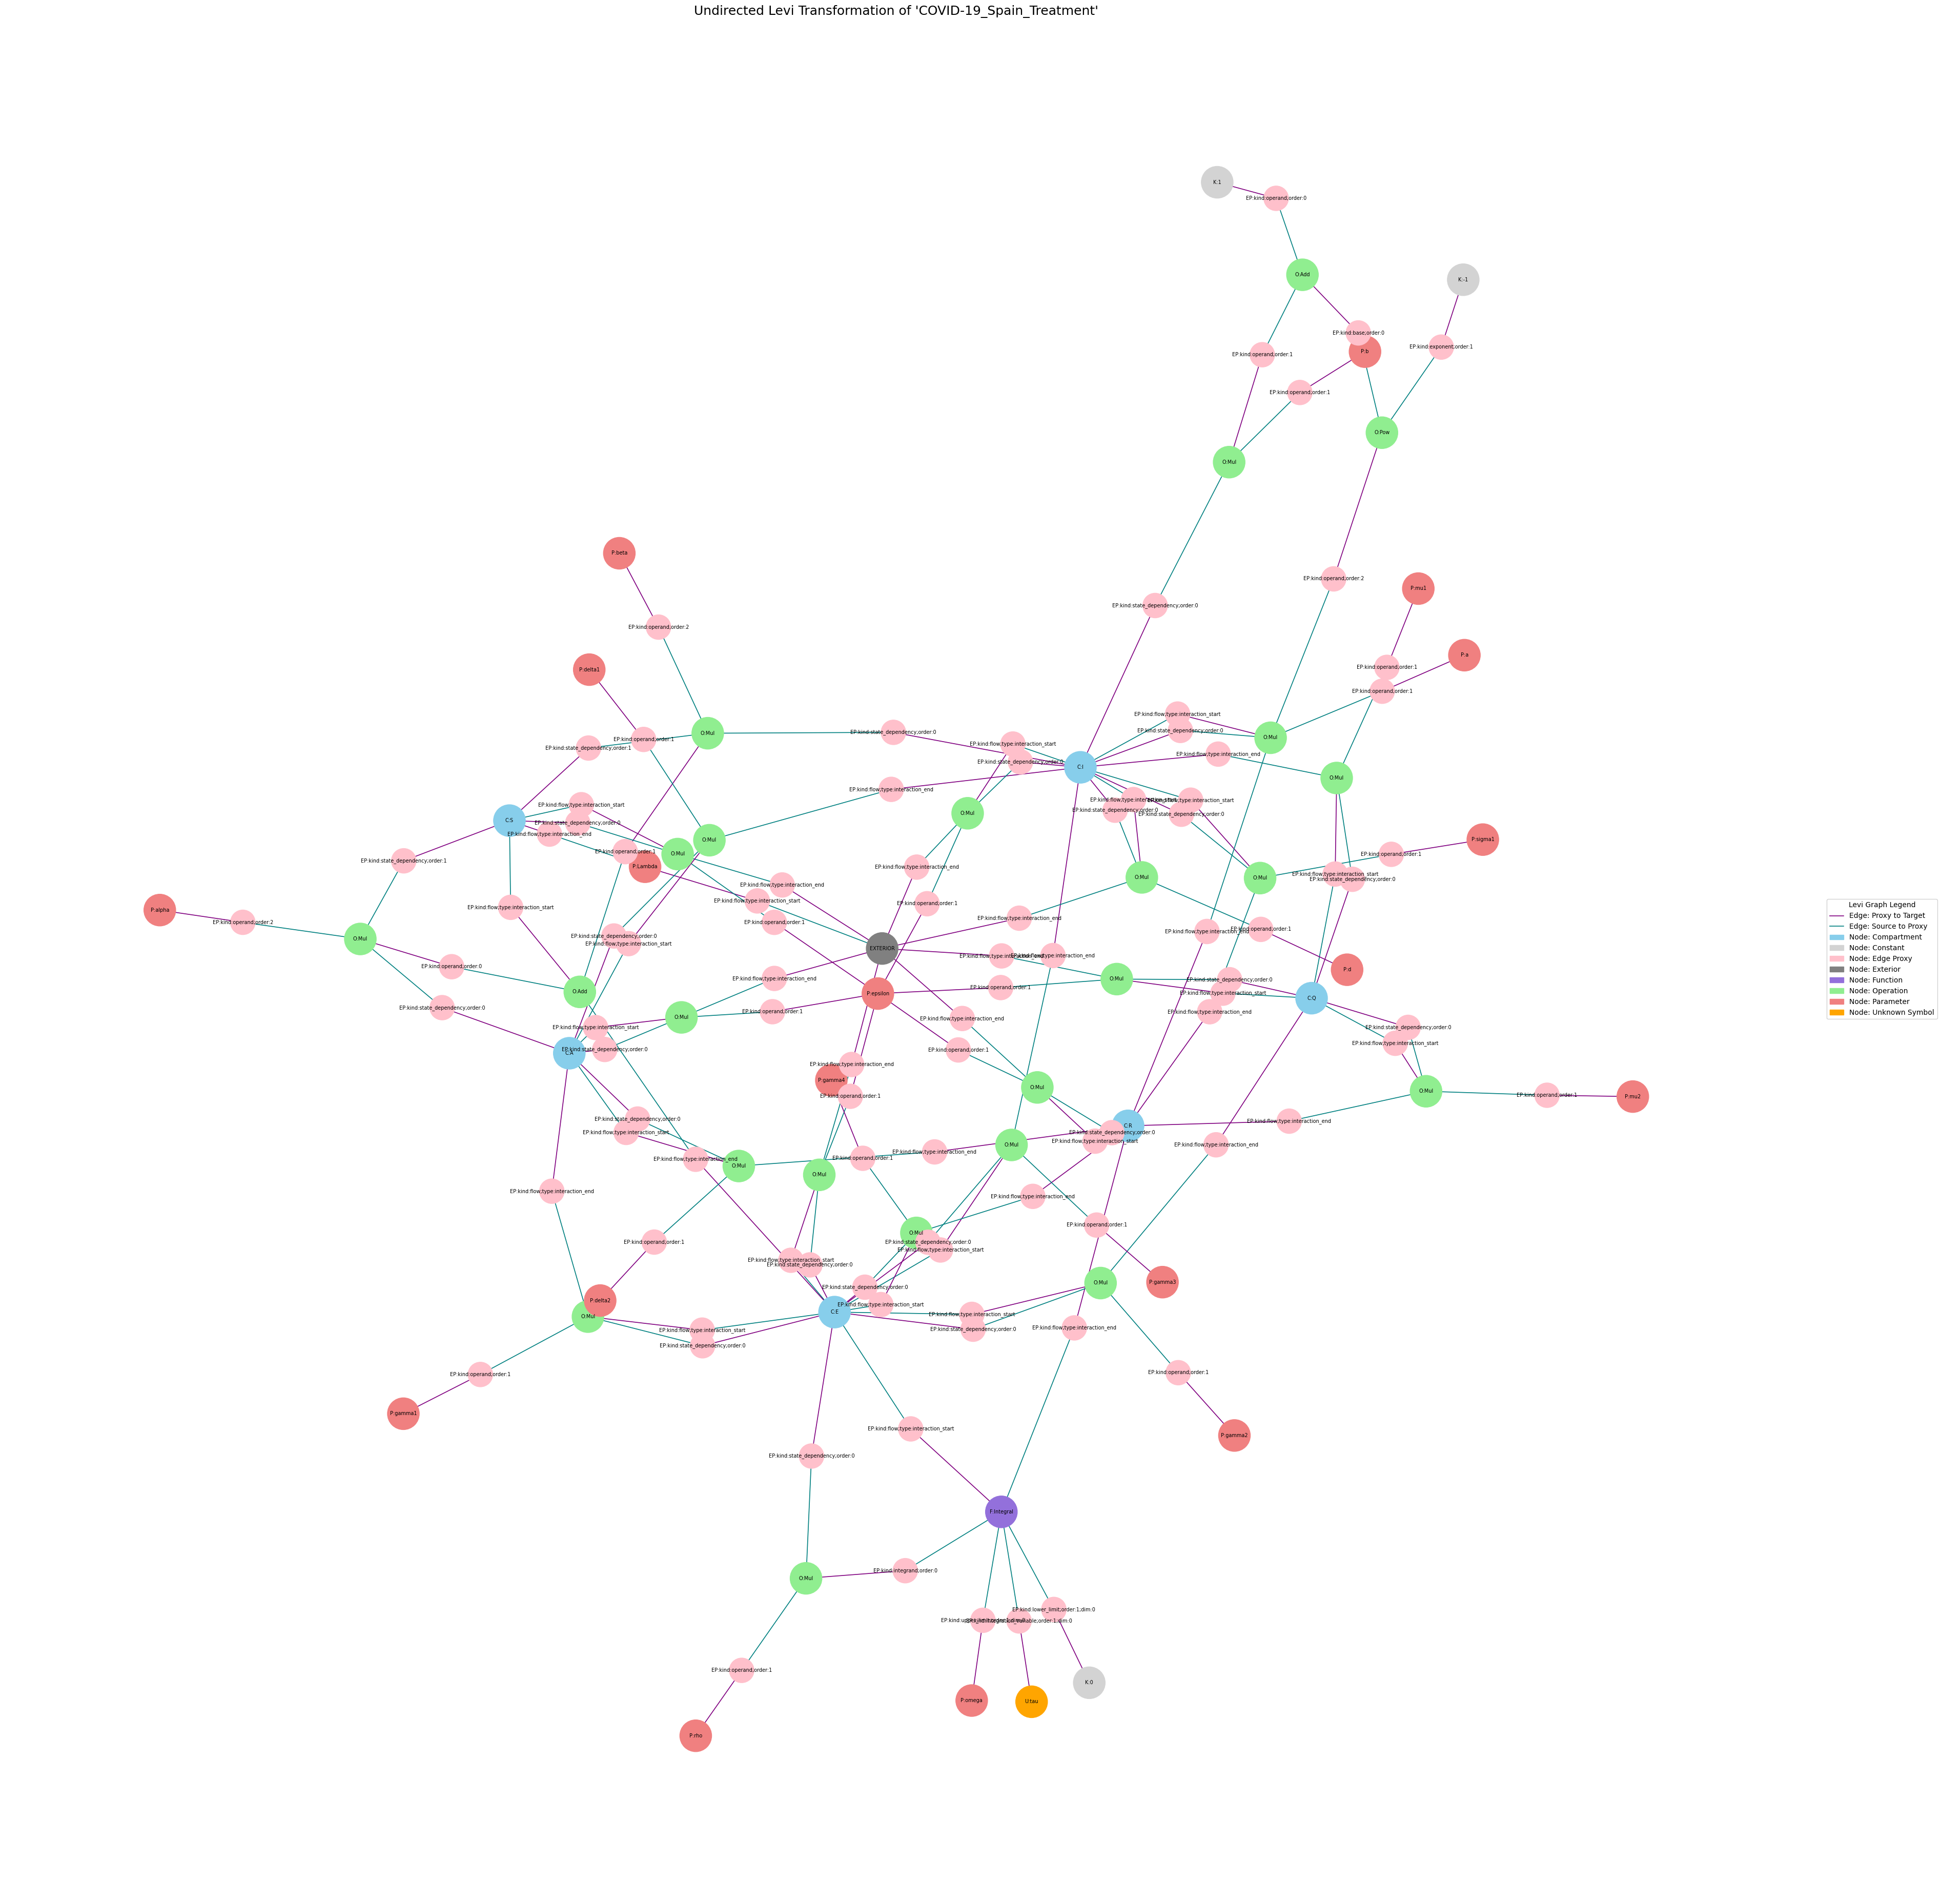

In [1]:
from __future__ import annotations

import itertools
from dataclasses import dataclass, field
from enum import Enum, auto
from typing import Any, Dict, Iterable, Iterator, List, Optional, Set, Tuple, Union

import networkx as nx
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches


try:
    import pydot
    from networkx.drawing.nx_pydot import graphviz_layout
    HAS_PYDOT = True
except ImportError:
    HAS_PYDOT = False

import numpy as np
if not hasattr(np, 'alltrue'):
    np.alltrue = np.all

class NodeRole(Enum):
    COMPARTMENT = auto()
    EXTERIOR = auto()  
    EXPR_OP = auto()       
    EXPR_FUNCTION = auto() 
    EXPR_SYMBOL = auto()   
    EXPR_CONSTANT = auto()
    EDGE_PROXY = auto() # New role for representing original edges

    def prefix(self) -> str:
        return {
            NodeRole.COMPARTMENT: "C",
            NodeRole.EXTERIOR: "X", 
            NodeRole.EXPR_OP: "O",
            NodeRole.EXPR_FUNCTION: "F", 
            NodeRole.EXPR_SYMBOL: "E", # Note: 'P:' and 'U:' are used for specific symbol types in practice
            NodeRole.EXPR_CONSTANT: "K",
            NodeRole.EDGE_PROXY: "EP", 
        }[self]

class InteractionType(Enum):
    FLOW = "flow"

@dataclass
class NodeData:
    role: NodeRole
    label: str 
    raw_label: str 
    sympy_obj: Optional[sp.Basic] = None
    attrs: Dict[str, Any] = field(default_factory=dict)

    def as_dict(self) -> Dict[str, Any]:
        d = dict(role=self.role, label=self.label, raw_label=self.raw_label, **self.attrs)
        if self.sympy_obj is not None:
            d["sympy_str"] = str(self.sympy_obj)
        return d

@dataclass
class Interaction:
    source: str 
    target: str 
    int_type: InteractionType 
    expr_root: str 

StateVarSet = Set[str]
ParamSet = Set[str]


def _depends_on(expr: sp.Basic, state_vars: StateVarSet) -> bool:
    if not isinstance(expr, sp.Basic):
        return False
    return any(str(s) in state_vars for s in expr.free_symbols)

def _expand_state_dependent_products(expr: sp.Basic, state_vars: StateVarSet) -> sp.Basic:
    if not isinstance(expr, sp.Basic): return expr
    processed_args = [_expand_state_dependent_products(a, state_vars) for a in expr.args]
    try: expr = expr.func(*processed_args)
    except Exception:
        try: expr = expr.func(*expr.args)
        except Exception: return expr
    if not isinstance(expr, sp.Mul): return expr
    non_sums, sums_to_expand = [], []
    for arg in expr.args:
        if isinstance(arg, sp.Add) and _depends_on(arg, state_vars): sums_to_expand.append(arg)
        else: non_sums.append(arg)
    if not sums_to_expand: return expr
    prod_root = sp.Mul(*non_sums) if non_sums else sp.Integer(1)
    current = prod_root
    for s in sums_to_expand:
        current = sp.expand(current * s)
        current = _expand_state_dependent_products(current, state_vars)
    return current

def _flatten_add(expr: sp.Basic) -> sp.Basic:
    if not isinstance(expr, sp.Basic) or not expr.args: return expr
    processed_args = [_flatten_add(a) for a in expr.args]
    if not isinstance(expr, sp.Add):
        try:
            if any(pa is not oa for pa, oa in zip(processed_args, expr.args)): return expr.func(*processed_args)
            else: return expr
        except Exception: return expr
    flat = []
    made_change_at_this_level = False
    for a in processed_args:
        if isinstance(a, sp.Add):
            flat.extend(a.args); made_change_at_this_level = True
        else: flat.append(a)
    children_changed = any(pa is not oa for pa, oa in zip(processed_args, expr.args))
    if made_change_at_this_level or children_changed: return sp.Add(*flat, evaluate=False)
    else: return expr

def canonicalize_expression(expr: sp.Basic,
                            state_vars: StateVarSet,
                            params: ParamSet,
                            level: str = "basic") -> sp.Basic:
    if not isinstance(expr, sp.Basic): return expr
    try: e = _expand_state_dependent_products(expr, state_vars)
    except Exception as exp_e: print(f"Warning: _expand_state_dependent_products failed for {expr}: {exp_e}. Using original."); e = expr
    try: e = _flatten_add(e)
    except Exception as flat_e: print(f"Warning: _flatten_add failed for {e}: {flat_e}. Using result from expansion.");
    original_for_simplify = e
    if level == "basic":
        try:
            e_cancel = sp.cancel(e)
            if e_cancel != original_for_simplify: e = e_cancel
            else: e = sp.simplify(e)
        except Exception as e_simp: print(f"Warning: Basic simplification (cancel/simplify) failed for {original_for_simplify}: {e_simp}. Using pre-simplification form."); e = original_for_simplify
    elif level == "full":
        try: e = sp.simplify(e)
        except Exception as e_full: print(f"Warning: Full simplification failed for {original_for_simplify}: {e_full}. Using pre-simplification form."); e = original_for_simplify
    elif level == "ratsimp":
         try: e = sp.ratsimp(e)
         except Exception as e_rat: print(f"Warning: Rational simplification (ratsimp) failed for {original_for_simplify}: {e_rat}. Using pre-simplification form."); e = original_for_simplify
    elif level == "none": pass
    else: raise ValueError(f"Unknown simplification level: {level}")
    return e


class EpiModelGraph:
    EXTERIOR_NODE_LABEL = "EXTERIOR"

    def __init__(self, name: str, state_vars: Iterable[str], params: Iterable[str]):
        self.name = name
        _state_vars = set(state_vars)
        if self.EXTERIOR_NODE_LABEL in _state_vars:
            raise ValueError(f"State variable name '{self.EXTERIOR_NODE_LABEL}' is reserved.")
        self.state_vars: StateVarSet = _state_vars
        self.params: ParamSet = set(params)
        self.g: nx.DiGraph = nx.DiGraph(name=name)
        self._ids = itertools.count()
        self._node_cache: Dict[Tuple[NodeRole, str], str] = {}
        self._shared_param_symbol_node_cache: Dict[sp.Symbol, str] = {}
        self._shared_constant_node_cache: Dict[sp.Basic, str] = {} 

        self.exterior_node_id = self._add_node(
            role=NodeRole.EXTERIOR,
            raw_label=self.EXTERIOR_NODE_LABEL,
            label=self.EXTERIOR_NODE_LABEL,
            always_create_new=False 
        )

        for comp in self.state_vars:
            self._add_node(role=NodeRole.COMPARTMENT,
                           raw_label=comp,
                           label=f"C:{comp}",
                           always_create_new=False) 

    def _new_id(self, role: NodeRole, raw: str) -> str:
        raw_simple = "".join(c for c in raw if c.isalnum())[:10]
        return f"{role.prefix()}_{raw_simple}_{next(self._ids)}"

    def _add_node(self, *,
                  role: NodeRole,
                  raw_label: str,
                  label: Optional[str] = None,
                  sympy_obj: Optional[sp.Basic] = None,
                  always_create_new: bool = False,
                  **attrs) -> str:
        cache_key = (role, raw_label)
        if not always_create_new and role in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR):
            if cache_key in self._node_cache:
                return self._node_cache[cache_key]

        display_label = label if label is not None else f"{role.prefix()}:{raw_label}"
        nid = self._new_id(role, raw_label)
        data = NodeData(role=role, label=display_label, raw_label=raw_label, sympy_obj=sympy_obj, attrs=attrs)
        self.g.add_node(nid, **data.as_dict())

        if not always_create_new and role in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR):
             self._node_cache[cache_key] = nid
        return nid

    def add_compartment(self, name: str, **attrs) -> str:
        if name == self.EXTERIOR_NODE_LABEL: raise ValueError(f"Cannot add compartment with reserved name '{self.EXTERIOR_NODE_LABEL}'.")
        if name in self.state_vars:
             print(f"Warning: Compartment '{name}' already exists.")
             return self._get_node_id(NodeRole.COMPARTMENT, name)
        self.state_vars.add(name)
        nid = self._add_node(role=NodeRole.COMPARTMENT, raw_label=name, label=f"C:{name}", always_create_new=False, **attrs)
        return nid

    def _get_node_id(self, role: NodeRole, raw_label: str) -> str:
        cache_key = (role, raw_label)
        if role not in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR) or cache_key not in self._node_cache:
            if role == NodeRole.EXPR_SYMBOL: 
                for sym, nid_ in self._shared_param_symbol_node_cache.items():
                    if str(sym) == raw_label:
                        return nid_
            raise KeyError(f"Node with role '{role}' and raw label '{raw_label}' not found in cache. Was it added?")
        return self._node_cache[cache_key]

    def _lookup_source_target_node(self, comp_or_exterior: str) -> str:
        if comp_or_exterior == self.EXTERIOR_NODE_LABEL: return self.exterior_node_id
        elif comp_or_exterior in self.state_vars: return self._get_node_id(NodeRole.COMPARTMENT, comp_or_exterior)
        else: raise ValueError(f"Unknown source/target '{comp_or_exterior}'. Must be a registered compartment or '{self.EXTERIOR_NODE_LABEL}'.")

    def add_interaction(self,
                        source: str,
                        target: str,
                        expr: sp.Expr,
                        canonical_level: str = "none") -> Interaction:
        int_type = InteractionType.FLOW
        src_nid = self._lookup_source_target_node(source)
        tgt_nid = self._lookup_source_target_node(target)

        if src_nid == tgt_nid:
             if source == self.EXTERIOR_NODE_LABEL: raise ValueError("Cannot add interaction from EXTERIOR to itself.")
             else: print(f"Warning: Adding interaction from compartment '{source}' to itself.")

        canon_expr = canonicalize_expression(expr, self.state_vars, self.params, level=canonical_level)
        root_nid = self._expr_to_subgraph(canon_expr)

        self.g.add_edge(src_nid, root_nid, kind=int_type.value, type="interaction_start")
        self.g.add_edge(root_nid, tgt_nid, kind=int_type.value, type="interaction_end")

        return Interaction(source=source, target=target, int_type=int_type, expr_root=root_nid)

    def _add_or_update_edge(self, u: str, v: str, **attrs_to_set: Any) -> None:
        if not self.g.has_edge(u, v):
            self.g.add_edge(u, v, **attrs_to_set)
        else:
            edge_data = self.g.edges[u, v]
            for key, new_value in attrs_to_set.items():
                if key not in edge_data: 
                    edge_data[key] = new_value
                else: 
                    existing_value = edge_data[key]
                    if existing_value == new_value:
                        continue

                    if key == 'order':
                        current_orders = []
                        if isinstance(existing_value, list): current_orders.extend(existing_value)
                        else: current_orders.append(existing_value)
                        
                        new_orders_to_add = []
                        if isinstance(new_value, list): new_orders_to_add.extend(new_value)
                        else: new_orders_to_add.append(new_value)

                        changed = False
                        for no_val in new_orders_to_add:
                            if no_val not in current_orders:
                                current_orders.append(no_val)
                                changed = True
                        if changed:
                            edge_data[key] = sorted(list(set(current_orders))) 
                    elif key == 'kind':
                        current_kinds = []
                        if isinstance(existing_value, list): current_kinds.extend(existing_value)
                        else: current_kinds.append(existing_value)
                        
                        new_kinds_to_add = []
                        if isinstance(new_value, list): new_kinds_to_add.extend(new_value)
                        else: new_kinds_to_add.append(new_value)

                        changed = False
                        for nk_val in new_kinds_to_add:
                            if nk_val not in current_kinds:
                                current_kinds.append(nk_val)
                                changed = True
                        
                        if changed:
                            updated_kinds = sorted(list(set(current_kinds)))
                            edge_data[key] = updated_kinds
                            if len(updated_kinds) > 1 :
                                print(f"Warning: Edge ({u}, {v}) attribute 'kind' merged to list: {updated_kinds}. Original: {existing_value}, Added: {new_value}")
                        elif len(current_kinds) == 1 and current_kinds[0] != existing_value and not isinstance(existing_value, list) :
                             edge_data[key] = current_kinds[0] 
                        elif len(current_kinds) == 1 and isinstance(existing_value, list) and len(existing_value) > 1:
                             edge_data[key] = current_kinds 
                    else: 
                        if edge_data.get(key) != new_value:
                            edge_data[key] = new_value

    def _expr_to_subgraph(self, expr: sp.Basic) -> str:
        local_expr_node_cache: Dict[sp.Basic, str] = {} 

        def _rec(e: sp.Basic) -> Tuple[str, bool]:
            # 1. Handle non-sympy objects
            if not isinstance(e, sp.Basic):
                 try: hash(e); cache_key = e
                 except TypeError: cache_key = repr(e)
                 if cache_key in local_expr_node_cache: return local_expr_node_cache[cache_key], False
                 raw_label_nonsympy = str(e)
                 print(f"Warning: Non-Sympy object '{raw_label_nonsympy}' encountered. Treating as Constant.")
                 nid_nonsympy = self._add_node(role=NodeRole.EXPR_CONSTANT,
                                      raw_label=raw_label_nonsympy,
                                      label=f"K:NonSympy_{type(e).__name__}",
                                      sympy_obj=None, 
                                      always_create_new=True) 
                 local_expr_node_cache[cache_key] = nid_nonsympy
                 return nid_nonsympy, False

            # 2. Check if 'e' is a Compartment node
            if isinstance(e, sp.Symbol):
                raw_label_str_comp = str(e)
                if raw_label_str_comp in self.state_vars:
                    comp_nid = self._get_node_id(NodeRole.COMPARTMENT, raw_label_str_comp)
                    return comp_nid, True 

            # 3. Check shared caches (parameter symbols, constants)
            is_param_symbol_to_share = False
            if isinstance(e, sp.Symbol):
                raw_label_str_param = str(e)
                if raw_label_str_param in self.params:
                    is_param_symbol_to_share = True
                    if e in self._shared_param_symbol_node_cache:
                        shared_param_nid = self._shared_param_symbol_node_cache[e]
                        local_expr_node_cache[e] = shared_param_nid 
                        return shared_param_nid, False 
            
            if isinstance(e, (sp.Number, sp.NumberSymbol)):
                if e in self._shared_constant_node_cache:
                    shared_const_nid = self._shared_constant_node_cache[e]
                    local_expr_node_cache[e] = shared_const_nid
                    return shared_const_nid, False

            # 4. Check local cache for this expression's recursion
            if e in local_expr_node_cache:
                return local_expr_node_cache[e], False

            # --- If not returned, it's a new node for this context ---
            nid: str
            attrs: Dict[str, Any] = {} 

            # --- SPECIAL HANDLING FOR sp.Integral ---
            if isinstance(e, sp.Integral):
                role_integral = NodeRole.EXPR_FUNCTION
                raw_label_integral = e.func.__name__ # "Integral"
                node_label_integral = f"{role_integral.prefix()}:{raw_label_integral}"
                nid = self._add_node(role=role_integral, raw_label=raw_label_integral, label=node_label_integral,
                                     sympy_obj=e, always_create_new=True, **attrs) # Pass empty attrs
                local_expr_node_cache[e] = nid

                if e.args: # Integrand is e.args[0]
                    integrand_expr = e.args[0]
                    integrand_nid, _ = _rec(integrand_expr)
                    self._add_or_update_edge(nid, integrand_nid, kind="integrand", order=0)

                for dim_idx, limit_spec in enumerate(e.limits):
                    limit_spec_arg_order = dim_idx + 1
                    
                    is_python_tuple = isinstance(limit_spec, tuple)
                    is_sympy_tuple = hasattr(sp, 'Tuple') and isinstance(limit_spec, sp.Tuple)

                    if not (is_python_tuple or is_sympy_tuple) or len(limit_spec) == 0:
                        print(f"Warning: Integral {nid} (Expr: {e}) has an invalid limit specification: {limit_spec} (type: {type(limit_spec)}). Skipping this limit spec.")
                        continue
                    
                    var_symbol = limit_spec[0]
                    var_nid, _ = _rec(var_symbol)
                    self._add_or_update_edge(nid, var_nid, kind="integration_variable", order=limit_spec_arg_order, dim_index=dim_idx)

                    if len(limit_spec) > 1 and limit_spec[1] is not None: # Lower limit
                        lower_limit_expr = limit_spec[1]
                        lower_nid, _ = _rec(lower_limit_expr)
                        self._add_or_update_edge(nid, lower_nid, kind="lower_limit", order=limit_spec_arg_order, dim_index=dim_idx)
                    
                    if len(limit_spec) > 2 and limit_spec[2] is not None: # Upper limit
                        upper_limit_expr = limit_spec[2]
                        upper_nid, _ = _rec(upper_limit_expr)
                        self._add_or_update_edge(nid, upper_nid, kind="upper_limit", order=limit_spec_arg_order, dim_index=dim_idx)
                return nid, False # Integral processed

            # --- GENERAL HANDLING for other Ops, Functions, and Leaves (if not Integral) ---
            force_creation = True 
            role_general: NodeRole
            raw_label_general: str = str(e) # Default raw_label for leaves
            node_label_general: str

            if e.args: 
                raw_label_general = e.func.__name__ 
                if issubclass(e.func, sp.Function): 
                    role_general = NodeRole.EXPR_FUNCTION
                    node_label_general = f"F:{raw_label_general}"
                else: 
                    role_general = NodeRole.EXPR_OP
                    node_label_general = f"O:{raw_label_general}"
            else: # Leaf node
                if isinstance(e, sp.Symbol): 
                    role_general = NodeRole.EXPR_SYMBOL
                    if is_param_symbol_to_share: # This is a NEW param symbol
                        force_creation = False 
                        attrs['symbol_type'] = 'param'; node_label_general = f"P:{raw_label_general}"
                    else: # Unknown symbol
                        attrs['symbol_type'] = 'unknown'; node_label_general = f"U:{raw_label_general}"
                elif isinstance(e, (sp.Number, sp.NumberSymbol)): # This is a NEW constant
                     role_general = NodeRole.EXPR_CONSTANT
                     node_label_general = f"K:{raw_label_general}"
                     force_creation = False 
                else: 
                     role_general = NodeRole.EXPR_SYMBOL 
                     print(f"Warning: Unhandled leaf expression type: {type(e)}. Treating as Symbol.")
                     node_label_general = f"U:{raw_label_general}" 
                     attrs['symbol_type'] = 'unhandled'
            
            nid = self._add_node(role=role_general, raw_label=raw_label_general, label=node_label_general,
                                 sympy_obj=e, always_create_new=force_creation, **attrs)
            
            if is_param_symbol_to_share and not force_creation: 
                self._shared_param_symbol_node_cache[e] = nid
            elif role_general == NodeRole.EXPR_CONSTANT and not force_creation: 
                self._shared_constant_node_cache[e] = nid
            
            local_expr_node_cache[e] = nid 

            if e.args: # This block is for non-Integral e with args
                is_pow = isinstance(e, sp.Pow) 
                for i, arg in enumerate(e.args):
                    child_id, child_is_compartment = _rec(arg)
                    edge_kind = "operand" 
                    if is_pow:
                        if i == 0: edge_kind = "base"
                        elif i == 1: edge_kind = "exponent"
                        else: print(f"Warning: Pow operation {nid} has unexpected argument index {i}.")
                    elif child_is_compartment:
                         edge_kind = "state_dependency"
                    self._add_or_update_edge(nid, child_id, kind=edge_kind, order=i)
            
            return nid, False

        root_nid, _ = _rec(expr)
        return root_nid

    def to_networkx(self) -> nx.DiGraph:
        return self.g

    def to_undirected_levi_graph(self) -> nx.Graph:
        undirected_g = nx.Graph(name=f"undirected_levi_{self.name}")
        
        for node_id, node_data in self.g.nodes(data=True):
            undirected_g.add_node(node_id, **node_data)

        edge_proxy_counter = 0
        for u, v, original_edge_data in self.g.edges(data=True):
            ep_node_id = self._new_id(NodeRole.EDGE_PROXY, f"edge_{u}_to_{v}")
            edge_proxy_counter +=1

            ep_label_parts = []
            if 'kind' in original_edge_data:
                kind_val = original_edge_data['kind']
                if isinstance(kind_val, list): ep_label_parts.append(f"kind:{','.join(map(str,kind_val))}")
                else: ep_label_parts.append(f"kind:{kind_val}")
            if 'type' in original_edge_data: ep_label_parts.append(f"type:{original_edge_data['type']}")
            if 'order' in original_edge_data:
                order_val = original_edge_data['order']
                if isinstance(order_val, list): ep_label_parts.append(f"order:{','.join(map(str,order_val))}")
                else: ep_label_parts.append(f"order:{order_val}")
            if 'dim_index' in original_edge_data:
                ep_label_parts.append(f"dim:{original_edge_data['dim_index']}")

            ep_label = f"{NodeRole.EDGE_PROXY.prefix()}:" + (";".join(ep_label_parts) if ep_label_parts else "edge")
            
            ep_node_attrs = {
                'role': NodeRole.EDGE_PROXY,
                'label': ep_label,
                'raw_label': f"proxy_for_edge_from_{u}_to_{v}", 
                'original_attributes': dict(original_edge_data), 
                'original_source_id': u, 
                'original_target_id': v  
            }
            undirected_g.add_node(ep_node_id, **ep_node_attrs)

            undirected_g.add_edge(u, ep_node_id, link_type="source_to_proxy")
            undirected_g.add_edge(ep_node_id, v, link_type="proxy_to_target")
            
        return undirected_g

    def summary(self) -> str:
        comps = sorted([d["raw_label"] for n, d in self.g.nodes(data=True) if d["role"] == NodeRole.COMPARTMENT])
        interactions = []
        num_expr_nodes = 0
        num_comp_nodes = 0
        num_ext_nodes = 0
        num_param_nodes = 0 

        for n, d in self.g.nodes(data=True):
            role = d.get("role")
            if role == NodeRole.COMPARTMENT: num_comp_nodes += 1
            elif role == NodeRole.EXTERIOR: num_ext_nodes += 1
            elif role == NodeRole.EXPR_SYMBOL and d.get('attrs', {}).get('symbol_type') == 'param': num_param_nodes +=1
            elif role in (NodeRole.EXPR_OP, NodeRole.EXPR_FUNCTION, NodeRole.EXPR_SYMBOL, NodeRole.EXPR_CONSTANT): num_expr_nodes +=1

        for u, v, d_edge in self.g.edges(data=True): # Renamed d to d_edge to avoid conflict
            if d_edge.get("type") == "interaction_start":
                 try:
                     u_data = self.g.nodes[u]
                     expr_root_nid = v
                     end_edge_target = None
                     for _, target_node, edge_data_out in self.g.out_edges(expr_root_nid, data=True):
                         if edge_data_out.get("type") == "interaction_end":
                             end_edge_target = target_node
                             break 

                     if end_edge_target:
                         tgt_data = self.g.nodes[end_edge_target]
                         start_kind = d_edge.get("kind", "unknown_flow")
                         if u_data["role"] in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR) and \
                            tgt_data["role"] in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR):
                             interactions.append((u_data["raw_label"], tgt_data["raw_label"], start_kind))
                     else: print(f"Warning: Could not find 'interaction_end' edge for expr root {expr_root_nid} starting from {u_data['raw_label']}.")
                 except KeyError as e: print(f"Warning: Node data missing during summary for edge ({u}, {v}): {e}")
                 except Exception as e: print(f"Warning: Error processing edge ({u}, {v}) for summary: {e}")
        
        return (f"EpiModelGraph(name={self.name!r}, "
                f"compartments={comps} ({num_comp_nodes}), "
                f"params_nodes={num_param_nodes}, " 
                f"exterior_nodes={num_ext_nodes}, "
                f"interactions={len(interactions)}, " 
                f"other_expression_nodes={num_expr_nodes})\\n" 
                f"Note: Other expression nodes include Operations (O:), Functions (F:), Unknowns (U:), and Constants (K:). Pow uses 'base'/'exponent' edges. State variable dependencies use 'state_dependency' edges. Integrals use 'integrand', 'integration_variable', 'lower_limit', 'upper_limit' edges.")


def visualize_levi_graph(levi_graph: nx.Graph, title: str = "Levi Graph Visualization", layout_prog: str = 'neato'):
    if not levi_graph.nodes:
        print("Graph is empty, cannot visualize.")
        return

    fig, ax = plt.subplots(figsize=(max(15, levi_graph.number_of_nodes() * 0.3), max(12, levi_graph.number_of_nodes() * 0.25)))

    node_color_defs = {
        'Compartment': ('skyblue', NodeRole.COMPARTMENT),
        'Exterior': ('grey', NodeRole.EXTERIOR),
        'Operation': ('lightgreen', NodeRole.EXPR_OP),
        'Function': ('mediumpurple', NodeRole.EXPR_FUNCTION),
        'Parameter': ('lightcoral', NodeRole.EXPR_SYMBOL, 'param'), 
        'Unknown Symbol': ('orange', NodeRole.EXPR_SYMBOL, 'unknown'),
        'Constant': ('lightgrey', NodeRole.EXPR_CONSTANT),
        'Unhandled Symbol': ('yellow', NodeRole.EXPR_SYMBOL, 'unhandled'),
        'Edge Proxy': ('pink', NodeRole.EDGE_PROXY)
    }
    node_colors = []
    node_sizes = []
    node_legend_handles = []
    seen_node_types = set()

    base_node_size = 2000
    for n_id_levi in levi_graph.nodes(): # Renamed n_id
        data_levi = levi_graph.nodes[n_id_levi] # Renamed data
        role_levi = data_levi.get('role') # Renamed role
        if not isinstance(role_levi, NodeRole):
            try: role_levi = NodeRole[str(role_levi).upper()] if isinstance(role_levi, str) else NodeRole.EXTERIOR 
            except KeyError: role_levi = NodeRole.EXTERIOR 
        
        symbol_type_levi = data_levi.get('attrs', {}).get('symbol_type', data_levi.get('symbol_type')) # Renamed symbol_type
        color_levi = 'white' # Renamed color
        size_levi = base_node_size # Renamed size
        node_type_key_levi = role_levi # Renamed node_type_key

        if role_levi == NodeRole.EXPR_SYMBOL and symbol_type_levi:
            node_type_key_levi = (role_levi, symbol_type_levi)
        elif role_levi == NodeRole.EDGE_PROXY:
            size_levi = base_node_size * 0.6 

        matched_legend_label_levi = None # Renamed matched_legend_label
        for legend_label_str_levi, definition_levi in node_color_defs.items(): # Renamed loop vars
            clr_levi, r_def_levi = definition_levi[0], definition_levi[1] # Renamed loop vars
            st_def_levi = definition_levi[2] if len(definition_levi) > 2 else None # Renamed loop vars
            
            current_def_key_levi = r_def_levi # Renamed loop var
            if st_def_levi: current_def_key_levi = (r_def_levi, st_def_levi)

            if node_type_key_levi == current_def_key_levi:
                color_levi = clr_levi
                matched_legend_label_levi = legend_label_str_levi
                break
        
        if matched_legend_label_levi and matched_legend_label_levi not in seen_node_types:
            node_legend_handles.append(mpatches.Patch(color=color_levi, label=f"Node: {matched_legend_label_levi}"))
            seen_node_types.add(matched_legend_label_levi)
        elif not matched_legend_label_levi and role_levi and role_levi.name not in seen_node_types:
            default_label_str_levi = f"Node: {role_levi.name} (Default)" # Renamed loop var
            node_legend_handles.append(mpatches.Patch(color=color_levi, label=default_label_str_levi))
            seen_node_types.add(role_levi.name)
            
        node_colors.append(color_levi)
        node_sizes.append(size_levi)

    labels = {n: levi_graph.nodes[n]['label'] for n in levi_graph.nodes()}

    pos = None
    if HAS_PYDOT:
        try:
            g_for_layout = levi_graph.copy()
            for n_id_layout, node_data_layout in g_for_layout.nodes(data=True):
                if 'label' in node_data_layout and isinstance(node_data_layout['label'], str) and ':' in node_data_layout['label']:
                    g_for_layout.nodes[n_id_layout]['label'] = f'"{node_data_layout["label"]}"' # Ensure labels with colons are quoted for dot
            pos = graphviz_layout(g_for_layout, prog=layout_prog) 
        except Exception as e:
            print(f"Warning: Pydot layout '{layout_prog}' failed ({e}). Using NetworkX spring_layout.")
            pos = nx.spring_layout(levi_graph, k=2.5/np.sqrt(levi_graph.number_of_nodes()) if levi_graph.number_of_nodes() > 0 else 1, 
                                   iterations=max(70, int(np.log(levi_graph.number_of_nodes() + 1)*30)), seed=42, scale=3.0)
    else:
        print("Warning: pydot not found. Using NetworkX spring_layout.")
        pos = nx.spring_layout(levi_graph, k=2.5/np.sqrt(levi_graph.number_of_nodes()) if levi_graph.number_of_nodes() > 0 else 1, 
                               iterations=max(70, int(np.log(levi_graph.number_of_nodes() + 1)*30)), seed=42, scale=3.0)

    edge_color_defs = {
        'Source to Proxy': ('teal', 'solid', 1.2, 'source_to_proxy'), 
        'Proxy to Target': ('purple', 'solid', 1.2, 'proxy_to_target'),
        'Other Link': ('darkgrey', 'dotted', 0.8, None) 
    }
    edge_colors = []
    edge_styles = []
    edge_widths = []
    edge_legend_handles = []
    seen_edge_types = set()

    for u_edge, v_edge, d_edge_levi in levi_graph.edges(data=True): # Renamed loop vars
        link_type_attr_levi = d_edge_levi.get('link_type') # Renamed loop var
        
        matched_legend_label_edge_levi = None # Renamed loop var
        for legend_label_str_edge_levi, definition_edge_levi in edge_color_defs.items(): # Renamed loop vars
            clr_edge, sty_edge, wid_edge, lt_def_edge = definition_edge_levi[0], definition_edge_levi[1], definition_edge_levi[2], definition_edge_levi[3] # Renamed loop vars
            if lt_def_edge == link_type_attr_levi:
                edge_colors.append(clr_edge); edge_styles.append(sty_edge); edge_widths.append(wid_edge)
                matched_legend_label_edge_levi = legend_label_str_edge_levi
                break
        
        if matched_legend_label_edge_levi:
            if matched_legend_label_edge_levi not in seen_edge_types:
                edge_legend_handles.append(mlines.Line2D([], [], color=edge_colors[-1], linestyle=edge_styles[-1], linewidth=edge_widths[-1], label=f"Edge: {matched_legend_label_edge_levi}"))
                seen_edge_types.add(matched_legend_label_edge_levi)
        else: 
            clr_other, sty_other, wid_other, _ = edge_color_defs['Other Link'] # Renamed loop vars
            edge_colors.append(clr_other); edge_styles.append(sty_other); edge_widths.append(wid_other)
            if 'Other Link' not in seen_edge_types:
                edge_legend_handles.append(mlines.Line2D([], [], color=clr_other, linestyle=sty_other, linewidth=wid_other, label="Edge: Other Link"))
                seen_edge_types.add('Other Link')

    nx.draw(levi_graph, pos, ax=ax, labels=labels, with_labels=True, 
            node_color=node_colors, node_size=node_sizes,
            edge_color=edge_colors, style=edge_styles, width=edge_widths,
            font_size=max(6, 10 - levi_graph.number_of_nodes()//40), 
            font_weight='normal', arrows=False)

    all_handles = sorted(node_legend_handles + edge_legend_handles, key=lambda x: x.get_label())
    if all_handles:
        ax.legend(handles=all_handles, loc='center left', bbox_to_anchor=(1.02, 0.5), 
                  fontsize='medium', title="Levi Graph Legend", framealpha=0.9)

    ax.set_title(title, fontsize=18)
    ax.axis('off')
    plt.tight_layout(rect=[0, 0, 0.85, 1]) 
    plt.show()

# --- Example Usage ---
state_vars = ['S', 'E', 'A', 'Q', 'I', 'R']
params = [
    'Lambda', 'alpha', 'beta',       
    'gamma1', 'gamma2', 'gamma3',    
    'delta1', 'mu1',                 
    'gamma4', 'delta2', 'mu2', 'sigma1', 
    'a', 'b',                        
    'd',                             
    'epsilon',                       
    'rho', 'omega'                   
]

symbols_list = state_vars + params
S, E, A, Q, I, R, Lambda, alpha, beta, gamma1, gamma2, gamma3, \
delta1, mu1, gamma4, delta2, mu2, sigma1, a, b, d, epsilon, rho, omega \
    = sp.symbols(symbols_list)

graph = EpiModelGraph(
    name="COVID-19_Spain_Treatment", 
    state_vars=state_vars,
    params=params 
)

graph.add_interaction(source=EpiModelGraph.EXTERIOR_NODE_LABEL, target='S', expr=Lambda)
infection_expr = (alpha*A + beta*I) * S
graph.add_interaction(source='S', target='E', expr=infection_expr)
graph.add_interaction(source='S', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * S) 
graph.add_interaction(source='E', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * E) 
graph.add_interaction(source='A', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * A) 
graph.add_interaction(source='Q', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * Q) 
graph.add_interaction(source='I', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * I) 
graph.add_interaction(source='R', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * R) 
graph.add_interaction(source='E', target='A', expr=gamma1 * E)
graph.add_interaction(source='E', target='Q', expr=gamma2 * E)
graph.add_interaction(source='E', target='I', expr=gamma3 * E)
graph.add_interaction(source='E', target='R', expr=gamma4 * E)
graph.add_interaction(source='A', target='I', expr=delta1 * A)
graph.add_interaction(source='A', target='R', expr=delta2 * A)
graph.add_interaction(source='Q', target='I', expr=mu1 * Q)
graph.add_interaction(source='Q', target='R', expr=mu2 * Q)
graph.add_interaction(source='I', target='R', expr=sigma1 * I) 
treatment_expr = (a / (sp.Integer(1) + b*I)) * I 
graph.add_interaction(source='I', target='R', expr=treatment_expr) 
graph.add_interaction(source='I', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=d * I) 

# Example with an integral
tau = sp.symbols('tau')
integral_expr = sp.Integral(rho * E, (tau, 0, omega))
graph.add_interaction(source='E', target='R', expr=integral_expr)


print("--- Original Directed Graph Summary ---")
print(graph.summary())
print(f"Number of nodes: {graph.to_networkx().number_of_nodes()}")
print(f"Number of edges: {graph.to_networkx().number_of_edges()}")
print("\n")

undirected_levi_g = graph.to_undirected_levi_graph()

print("--- Undirected Levi Graph Summary ---")
print(f"Name: {undirected_levi_g.name}")
print(f"Number of nodes: {undirected_levi_g.number_of_nodes()}")
print(f"Number of edges: {undirected_levi_g.number_of_edges()}")

print("\nExample nodes in Levi graph:")
original_nodes_count = 0
edge_proxy_nodes_count = 0
for i, (node_id, data) in enumerate(undirected_levi_g.nodes(data=True)):
    if data.get('role') == NodeRole.EDGE_PROXY:
        edge_proxy_nodes_count +=1
        if edge_proxy_nodes_count <= 3: # Show a few more proxy nodes
             print(f"  EP Node ID: {node_id}, Label: {data.get('label')}, Orig Src: {data.get('original_source_id')}, Orig Tgt: {data.get('original_target_id')}")
    else:
        original_nodes_count +=1
        if original_nodes_count <= 3 and data.get('role') != NodeRole.EXTERIOR : # Show a few more original nodes
            print(f"  Orig Node ID: {node_id}, Role: {data.get('role')}, Label: {data.get('label')}")

print(f"\nTotal original nodes represented: {original_nodes_count}")
print(f"Total edge proxy nodes created: {edge_proxy_nodes_count}")
print("\n")

visualize_levi_graph(undirected_levi_g, 
                     title=f"Undirected Levi Transformation of '{graph.name}'", 
                     layout_prog='sfdp' if HAS_PYDOT else 'spring')

In [ ]:
from __future__ import annotations

import itertools
from dataclasses import dataclass, field
from enum import Enum, auto
from typing import Any, Dict, Iterable, Iterator, List, Optional, Set, Tuple, Union

import networkx as nx
import sympy as sp
import torch # Ajout de l'import torch ici

# --- Début des définitions de classes de EpiModelGraph (copiées depuis votre code) ---
# (J'ai légèrement réorganisé pour la clarté et supprimé les imports matplotlib/pydot non utilisés ici)

class NodeRole(Enum):
    COMPARTMENT = auto()
    EXTERIOR = auto()
    EXPR_OP = auto()
    EXPR_FUNCTION = auto()
    EXPR_SYMBOL = auto()
    EXPR_CONSTANT = auto()
    EDGE_PROXY = auto() # New role for representing original edges

    def prefix(self) -> str:
        return {
            NodeRole.COMPARTMENT: "C",
            NodeRole.EXTERIOR: "X",
            NodeRole.EXPR_OP: "O",
            NodeRole.EXPR_FUNCTION: "F",
            NodeRole.EXPR_SYMBOL: "E",
            NodeRole.EXPR_CONSTANT: "K",
            NodeRole.EDGE_PROXY: "EP",
        }[self]

class InteractionType(Enum):
    FLOW = "flow"

@dataclass
class NodeData:
    role: NodeRole
    label: str
    raw_label: str
    sympy_obj: Optional[sp.Basic] = None
    attrs: Dict[str, Any] = field(default_factory=dict)

    def as_dict(self) -> Dict[str, Any]:
        d = dict(role=self.role, label=self.label, raw_label=self.raw_label, **self.attrs)
        if self.sympy_obj is not None:
            d["sympy_str"] = str(self.sympy_obj)
        return d

@dataclass
class Interaction:
    source: str
    target: str
    int_type: InteractionType
    expr_root: str

StateVarSet = Set[str]
ParamSet = Set[str]


def _depends_on(expr: sp.Basic, state_vars: StateVarSet) -> bool:
    if not isinstance(expr, sp.Basic):
        return False
    return any(str(s) in state_vars for s in expr.free_symbols)

def _expand_state_dependent_products(expr: sp.Basic, state_vars: StateVarSet) -> sp.Basic:
    if not isinstance(expr, sp.Basic): return expr
    processed_args = [_expand_state_dependent_products(a, state_vars) for a in expr.args]
    try: expr = expr.func(*processed_args)
    except Exception:
        try: expr = expr.func(*expr.args)
        except Exception: return expr
    if not isinstance(expr, sp.Mul): return expr
    non_sums, sums_to_expand = [], []
    for arg in expr.args:
        if isinstance(arg, sp.Add) and _depends_on(arg, state_vars): sums_to_expand.append(arg)
        else: non_sums.append(arg)
    if not sums_to_expand: return expr
    prod_root = sp.Mul(*non_sums) if non_sums else sp.Integer(1)
    current = prod_root
    for s in sums_to_expand:
        current = sp.expand(current * s)
        current = _expand_state_dependent_products(current, state_vars)
    return current

def _flatten_add(expr: sp.Basic) -> sp.Basic:
    if not isinstance(expr, sp.Basic) or not expr.args: return expr
    processed_args = [_flatten_add(a) for a in expr.args]
    if not isinstance(expr, sp.Add):
        try:
            if any(pa is not oa for pa, oa in zip(processed_args, expr.args)): return expr.func(*processed_args)
            else: return expr
        except Exception: return expr
    flat = []
    made_change_at_this_level = False
    for a in processed_args:
        if isinstance(a, sp.Add):
            flat.extend(a.args); made_change_at_this_level = True
        else: flat.append(a)
    children_changed = any(pa is not oa for pa, oa in zip(processed_args, expr.args))
    if made_change_at_this_level or children_changed: return sp.Add(*flat, evaluate=False)
    else: return expr

def canonicalize_expression(expr: sp.Basic,
                            state_vars: StateVarSet,
                            params: ParamSet,
                            level: str = "basic") -> sp.Basic:
    if not isinstance(expr, sp.Basic): return expr
    try: e = _expand_state_dependent_products(expr, state_vars)
    except Exception as exp_e: print(f"Warning: _expand_state_dependent_products failed for {expr}: {exp_e}. Using original."); e = expr
    try: e = _flatten_add(e)
    except Exception as flat_e: print(f"Warning: _flatten_add failed for {e}: {flat_e}. Using result from expansion.");
    original_for_simplify = e
    if level == "basic":
        try:
            e_cancel = sp.cancel(e)
            if e_cancel != original_for_simplify: e = e_cancel
            else: e = sp.simplify(e)
        except Exception as e_simp: print(f"Warning: Basic simplification (cancel/simplify) failed for {original_for_simplify}: {e_simp}. Using pre-simplification form."); e = original_for_simplify
    elif level == "full":
        try: e = sp.simplify(e)
        except Exception as e_full: print(f"Warning: Full simplification failed for {original_for_simplify}: {e_full}. Using pre-simplification form."); e = original_for_simplify
    elif level == "ratsimp":
         try: e = sp.ratsimp(e)
         except Exception as e_rat: print(f"Warning: Rational simplification (ratsimp) failed for {original_for_simplify}: {e_rat}. Using pre-simplification form."); e = original_for_simplify
    elif level == "none": pass
    else: raise ValueError(f"Unknown simplification level: {level}")
    return e


class EpiModelGraph:
    EXTERIOR_NODE_LABEL = "EXTERIOR"

    def __init__(self, name: str, state_vars: Iterable[str], params: Iterable[str]):
        self.name = name
        _state_vars = set(state_vars)
        if self.EXTERIOR_NODE_LABEL in _state_vars:
            raise ValueError(f"State variable name '{self.EXTERIOR_NODE_LABEL}' is reserved.")
        self.state_vars: StateVarSet = _state_vars
        self.params: ParamSet = set(params)
        self.g: nx.DiGraph = nx.DiGraph(name=name)
        self._ids = itertools.count()
        self._node_cache: Dict[Tuple[NodeRole, str], str] = {}
        self._shared_param_symbol_node_cache: Dict[sp.Symbol, str] = {}
        self._shared_constant_node_cache: Dict[sp.Basic, str] = {}

        self.exterior_node_id = self._add_node(
            role=NodeRole.EXTERIOR,
            raw_label=self.EXTERIOR_NODE_LABEL,
            label=self.EXTERIOR_NODE_LABEL,
            always_create_new=False
        )

        for comp in self.state_vars:
            self._add_node(role=NodeRole.COMPARTMENT,
                           raw_label=comp,
                           label=f"C:{comp}",
                           always_create_new=False)

    def _new_id(self, role: NodeRole, raw: str) -> str:
        raw_simple = "".join(c for c in raw if c.isalnum())[:10]
        return f"{role.prefix()}_{raw_simple}_{next(self._ids)}"

    def _add_node(self, *,
                  role: NodeRole,
                  raw_label: str,
                  label: Optional[str] = None,
                  sympy_obj: Optional[sp.Basic] = None,
                  always_create_new: bool = False,
                  **attrs) -> str:
        cache_key = (role, raw_label)
        if not always_create_new and role in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR):
            if cache_key in self._node_cache:
                return self._node_cache[cache_key]

        display_label = label if label is not None else f"{role.prefix()}:{raw_label}"
        nid = self._new_id(role, raw_label)
        data = NodeData(role=role, label=display_label, raw_label=raw_label, sympy_obj=sympy_obj, attrs=attrs)
        self.g.add_node(nid, **data.as_dict())

        if not always_create_new and role in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR):
             self._node_cache[cache_key] = nid
        return nid

    def add_compartment(self, name: str, **attrs) -> str:
        if name == self.EXTERIOR_NODE_LABEL: raise ValueError(f"Cannot add compartment with reserved name '{self.EXTERIOR_NODE_LABEL}'.")
        if name in self.state_vars:
             print(f"Warning: Compartment '{name}' already exists.")
             return self._get_node_id(NodeRole.COMPARTMENT, name)
        self.state_vars.add(name)
        nid = self._add_node(role=NodeRole.COMPARTMENT, raw_label=name, label=f"C:{name}", always_create_new=False, **attrs)
        return nid

    def _get_node_id(self, role: NodeRole, raw_label: str) -> str:
        cache_key = (role, raw_label)
        if role not in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR) or cache_key not in self._node_cache:
            if role == NodeRole.EXPR_SYMBOL:
                for sym, nid_ in self._shared_param_symbol_node_cache.items():
                    if str(sym) == raw_label:
                        return nid_
            raise KeyError(f"Node with role '{role}' and raw label '{raw_label}' not found in cache. Was it added?")
        return self._node_cache[cache_key]

    def _lookup_source_target_node(self, comp_or_exterior: str) -> str:
        if comp_or_exterior == self.EXTERIOR_NODE_LABEL: return self.exterior_node_id
        elif comp_or_exterior in self.state_vars: return self._get_node_id(NodeRole.COMPARTMENT, comp_or_exterior)
        else: raise ValueError(f"Unknown source/target '{comp_or_exterior}'. Must be a registered compartment or '{self.EXTERIOR_NODE_LABEL}'.")

    def add_interaction(self,
                        source: str,
                        target: str,
                        expr: sp.Expr,
                        canonical_level: str = "none") -> Interaction:
        int_type = InteractionType.FLOW
        src_nid = self._lookup_source_target_node(source)
        tgt_nid = self._lookup_source_target_node(target)

        if src_nid == tgt_nid:
             if source == self.EXTERIOR_NODE_LABEL: raise ValueError("Cannot add interaction from EXTERIOR to itself.")
             else: print(f"Warning: Adding interaction from compartment '{source}' to itself.")

        canon_expr = canonicalize_expression(expr, self.state_vars, self.params, level=canonical_level)
        root_nid = self._expr_to_subgraph(canon_expr)

        self.g.add_edge(src_nid, root_nid, kind=int_type.value, type="interaction_start")
        self.g.add_edge(root_nid, tgt_nid, kind=int_type.value, type="interaction_end")

        return Interaction(source=source, target=target, int_type=int_type, expr_root=root_nid)

    def _add_or_update_edge(self, u: str, v: str, **attrs_to_set: Any) -> None:
        if not self.g.has_edge(u, v):
            self.g.add_edge(u, v, **attrs_to_set)
        else:
            edge_data = self.g.edges[u, v]
            for key, new_value in attrs_to_set.items():
                if key not in edge_data:
                    edge_data[key] = new_value
                else:
                    existing_value = edge_data[key]
                    if existing_value == new_value:
                        continue

                    if key == 'order':
                        current_orders = []
                        if isinstance(existing_value, list): current_orders.extend(existing_value)
                        else: current_orders.append(existing_value)

                        new_orders_to_add = []
                        if isinstance(new_value, list): new_orders_to_add.extend(new_value)
                        else: new_orders_to_add.append(new_value)

                        changed = False
                        for no_val in new_orders_to_add:
                            if no_val not in current_orders:
                                current_orders.append(no_val)
                                changed = True
                        if changed:
                            edge_data[key] = sorted(list(set(current_orders)))
                    elif key == 'kind':
                        current_kinds = []
                        if isinstance(existing_value, list): current_kinds.extend(existing_value)
                        else: current_kinds.append(existing_value)

                        new_kinds_to_add = []
                        if isinstance(new_value, list): new_kinds_to_add.extend(new_value)
                        else: new_kinds_to_add.append(new_value)

                        changed = False
                        for nk_val in new_kinds_to_add:
                            if nk_val not in current_kinds:
                                current_kinds.append(nk_val)
                                changed = True

                        if changed:
                            updated_kinds = sorted(list(set(current_kinds)))
                            edge_data[key] = updated_kinds
                            if len(updated_kinds) > 1 :
                                print(f"Warning: Edge ({u}, {v}) attribute 'kind' merged to list: {updated_kinds}. Original: {existing_value}, Added: {new_value}")
                        elif len(current_kinds) == 1 and current_kinds[0] != existing_value and not isinstance(existing_value, list) :
                             edge_data[key] = current_kinds[0]
                        elif len(current_kinds) == 1 and isinstance(existing_value, list) and len(existing_value) > 1:
                             edge_data[key] = current_kinds
                    else:
                        if edge_data.get(key) != new_value:
                            edge_data[key] = new_value

    def _expr_to_subgraph(self, expr: sp.Basic) -> str:
        local_expr_node_cache: Dict[sp.Basic, str] = {}

        def _rec(e: sp.Basic) -> Tuple[str, bool]:
            if not isinstance(e, sp.Basic):
                 try: hash(e); cache_key = e
                 except TypeError: cache_key = repr(e)
                 if cache_key in local_expr_node_cache: return local_expr_node_cache[cache_key], False
                 raw_label_nonsympy = str(e)
                 print(f"Warning: Non-Sympy object '{raw_label_nonsympy}' encountered. Treating as Constant.")
                 nid_nonsympy = self._add_node(role=NodeRole.EXPR_CONSTANT,
                                      raw_label=raw_label_nonsympy,
                                      label=f"K:NonSympy_{type(e).__name__}",
                                      sympy_obj=None,
                                      always_create_new=True)
                 local_expr_node_cache[cache_key] = nid_nonsympy
                 return nid_nonsympy, False

            if isinstance(e, sp.Symbol):
                raw_label_str_comp = str(e)
                if raw_label_str_comp in self.state_vars:
                    comp_nid = self._get_node_id(NodeRole.COMPARTMENT, raw_label_str_comp)
                    return comp_nid, True

            is_param_symbol_to_share = False
            if isinstance(e, sp.Symbol):
                raw_label_str_param = str(e)
                if raw_label_str_param in self.params:
                    is_param_symbol_to_share = True
                    if e in self._shared_param_symbol_node_cache:
                        shared_param_nid = self._shared_param_symbol_node_cache[e]
                        local_expr_node_cache[e] = shared_param_nid
                        return shared_param_nid, False

            if isinstance(e, (sp.Number, sp.NumberSymbol)):
                if e in self._shared_constant_node_cache:
                    shared_const_nid = self._shared_constant_node_cache[e]
                    local_expr_node_cache[e] = shared_const_nid
                    return shared_const_nid, False

            if e in local_expr_node_cache:
                return local_expr_node_cache[e], False

            nid: str
            attrs: Dict[str, Any] = {}

            if isinstance(e, sp.Integral):
                role_integral = NodeRole.EXPR_FUNCTION
                raw_label_integral = e.func.__name__
                node_label_integral = f"{role_integral.prefix()}:{raw_label_integral}"
                nid = self._add_node(role=role_integral, raw_label=raw_label_integral, label=node_label_integral,
                                     sympy_obj=e, always_create_new=True, **attrs)
                local_expr_node_cache[e] = nid

                if e.args:
                    integrand_expr = e.args[0]
                    integrand_nid, _ = _rec(integrand_expr)
                    self._add_or_update_edge(nid, integrand_nid, kind="integrand", order=0)

                for dim_idx, limit_spec in enumerate(e.limits):
                    limit_spec_arg_order = dim_idx + 1
                    is_python_tuple = isinstance(limit_spec, tuple)
                    is_sympy_tuple = hasattr(sp, 'Tuple') and isinstance(limit_spec, sp.Tuple)

                    if not (is_python_tuple or is_sympy_tuple) or len(limit_spec) == 0:
                        print(f"Warning: Integral {nid} (Expr: {e}) has an invalid limit specification: {limit_spec} (type: {type(limit_spec)}). Skipping this limit spec.")
                        continue

                    var_symbol = limit_spec[0]
                    var_nid, _ = _rec(var_symbol)
                    self._add_or_update_edge(nid, var_nid, kind="integration_variable", order=limit_spec_arg_order, dim_index=dim_idx)

                    if len(limit_spec) > 1 and limit_spec[1] is not None:
                        lower_limit_expr = limit_spec[1]
                        lower_nid, _ = _rec(lower_limit_expr)
                        self._add_or_update_edge(nid, lower_nid, kind="lower_limit", order=limit_spec_arg_order, dim_index=dim_idx)

                    if len(limit_spec) > 2 and limit_spec[2] is not None:
                        upper_limit_expr = limit_spec[2]
                        upper_nid, _ = _rec(upper_limit_expr)
                        self._add_or_update_edge(nid, upper_nid, kind="upper_limit", order=limit_spec_arg_order, dim_index=dim_idx)
                return nid, False

            force_creation = True
            role_general: NodeRole
            raw_label_general: str = str(e)
            node_label_general: str

            if e.args:
                raw_label_general = e.func.__name__
                if issubclass(e.func, sp.Function):
                    role_general = NodeRole.EXPR_FUNCTION
                    node_label_general = f"F:{raw_label_general}"
                else:
                    role_general = NodeRole.EXPR_OP
                    node_label_general = f"O:{raw_label_general}"
            else:
                if isinstance(e, sp.Symbol):
                    role_general = NodeRole.EXPR_SYMBOL
                    if is_param_symbol_to_share:
                        force_creation = False
                        attrs['symbol_type'] = 'param'; node_label_general = f"P:{raw_label_general}"
                    else:
                        attrs['symbol_type'] = 'unknown'; node_label_general = f"U:{raw_label_general}"
                elif isinstance(e, (sp.Number, sp.NumberSymbol)):
                     role_general = NodeRole.EXPR_CONSTANT
                     node_label_general = f"K:{raw_label_general}"
                     force_creation = False
                else:
                     role_general = NodeRole.EXPR_SYMBOL
                     print(f"Warning: Unhandled leaf expression type: {type(e)}. Treating as Symbol.")
                     node_label_general = f"U:{raw_label_general}"
                     attrs['symbol_type'] = 'unhandled'

            nid = self._add_node(role=role_general, raw_label=raw_label_general, label=node_label_general,
                                 sympy_obj=e, always_create_new=force_creation, **attrs)

            if is_param_symbol_to_share and not force_creation:
                self._shared_param_symbol_node_cache[e] = nid
            elif role_general == NodeRole.EXPR_CONSTANT and not force_creation:
                self._shared_constant_node_cache[e] = nid

            local_expr_node_cache[e] = nid

            if e.args:
                is_pow = isinstance(e, sp.Pow)
                for i, arg in enumerate(e.args):
                    child_id, child_is_compartment = _rec(arg)
                    edge_kind = "operand"
                    if is_pow:
                        if i == 0: edge_kind = "base"
                        elif i == 1: edge_kind = "exponent"
                        else: print(f"Warning: Pow operation {nid} has unexpected argument index {i}.")
                    elif child_is_compartment:
                         edge_kind = "state_dependency"
                    self._add_or_update_edge(nid, child_id, kind=edge_kind, order=i)

            return nid, False

        root_nid, _ = _rec(expr)
        return root_nid

    def to_networkx(self) -> nx.DiGraph:
        return self.g

    def to_undirected_levi_graph(self) -> nx.Graph:
        undirected_g = nx.Graph(name=f"undirected_levi_{self.name}")

        for node_id, node_data in self.g.nodes(data=True):
            undirected_g.add_node(node_id, **node_data)

        edge_proxy_counter = 0
        for u, v, original_edge_data in self.g.edges(data=True):
            ep_node_id = self._new_id(NodeRole.EDGE_PROXY, f"edge_{u}_to_{v}")
            edge_proxy_counter +=1

            ep_label_parts = []
            if 'kind' in original_edge_data:
                kind_val = original_edge_data['kind']
                if isinstance(kind_val, list): ep_label_parts.append(f"kind:{','.join(map(str,kind_val))}")
                else: ep_label_parts.append(f"kind:{kind_val}")
            if 'type' in original_edge_data: ep_label_parts.append(f"type:{original_edge_data['type']}")
            if 'order' in original_edge_data:
                order_val = original_edge_data['order']
                if isinstance(order_val, list): ep_label_parts.append(f"order:{','.join(map(str,order_val))}")
                else: ep_label_parts.append(f"order:{order_val}")
            if 'dim_index' in original_edge_data:
                ep_label_parts.append(f"dim:{original_edge_data['dim_index']}")

            ep_label = f"{NodeRole.EDGE_PROXY.prefix()}:" + (";".join(ep_label_parts) if ep_label_parts else "edge")

            ep_node_attrs = {
                'role': NodeRole.EDGE_PROXY,
                'label': ep_label,
                'raw_label': f"proxy_for_edge_from_{u}_to_{v}",
                'original_attributes': dict(original_edge_data),
                'original_source_id': u,
                'original_target_id': v
            }
            undirected_g.add_node(ep_node_id, **ep_node_attrs)

            undirected_g.add_edge(u, ep_node_id, link_type="source_to_proxy")
            undirected_g.add_edge(ep_node_id, v, link_type="proxy_to_target")

        return undirected_g

# --- Fin des définitions de classes de EpiModelGraph ---


# --- Début du code de conversion et d'exemple ---

def get_ged_label_type(node_data: Dict[str, Any]) -> str:
    """
    Détermine le type de label unique pour un nœud donné pour le calcul de la GED.
    Ignore 'order:x' pour les nœuds EDGE_PROXY.
    """
    role = node_data.get('role')
    original_label = node_data.get('label', '') # Le 'label' généré par EpiModelGraph

    if not isinstance(role, NodeRole): # Gérer le cas où le rôle pourrait être une chaîne
        try:
            # Tente de faire correspondre la fin de la chaîne à un nom d'enum, par ex. 'NodeRole.COMPARTMENT' -> 'COMPARTMENT'
            role = NodeRole[str(role).split('.')[-1].upper()] if isinstance(role, str) else NodeRole.EXTERIOR
        except KeyError:
            role = NodeRole.EXTERIOR # Valeur par défaut si la conversion échoue
            print(f"Avertissement : Rôle inconnu '{node_data.get('role')}' converti en EXTERIOR. Label original: {original_label}")


    if role == NodeRole.EDGE_PROXY:
        label_prefix = f"{NodeRole.EDGE_PROXY.prefix()}:"
        if original_label.startswith(label_prefix):
            parts_str = original_label[len(label_prefix):]
            attributes = parts_str.split(';')
            
            filtered_attributes = []
            for attr in attributes:
                if attr.startswith("order:"):
                    continue 
                filtered_attributes.append(attr)
            
            filtered_attributes.sort() 
            
            if filtered_attributes:
                return f"{label_prefix}{';'.join(filtered_attributes)}"
            else:
                return f"{label_prefix}edge_generic"
        else:
            print(f"Avertissement : Format de label EDGE_PROXY inattendu : '{original_label}'. Utilisation comme tel.")
            return original_label 
            
    elif role == NodeRole.EXPR_SYMBOL:
        return original_label # P:param, U:unknown, C:comp (si utilisé comme symbole dans une expr)
        
    elif role in [NodeRole.COMPARTMENT, NodeRole.EXTERIOR, NodeRole.EXPR_OP, 
                  NodeRole.EXPR_FUNCTION, NodeRole.EXPR_CONSTANT]:
        return original_label # C:S, O:Add, K:1 etc.
    else:
        print(f"Avertissement : Rôle de nœud non géré '{role}' pour la génération de label GED. Utilisation du label original : {original_label}")
        return original_label


def convert_epimodel_to_ged_input(
    epi_model_graph: EpiModelGraph, # Type hint avec la classe définie ci-dessus
    global_label_vocab: Optional[List[str]] = None, # Pour la cohérence entre plusieurs graphes
    device: torch.device = torch.device('cpu')
) -> Tuple[Dict[str, Any], List[str]]:
    """
    Convertit un EpiModelGraph en format d'entrée pour les modèles GED (comme GEDGW).

    Args:
        epi_model_graph: L'instance EpiModelGraph à convertir.
        global_label_vocab: Optionnel. Une liste pré-définie et triée de tous les types de labels uniques
                             attendus dans l'ensemble de données. Si fournie, elle est utilisée pour
                             le one-hot encoding. Si None, un vocabulaire est construit localement
                             à partir de ce graphe uniquement.
        device: Le device PyTorch sur lequel créer les tenseurs.

    Returns:
        Un tuple contenant:
        - Un dictionnaire avec les clés "n" (int), "edge_index" (Tensor), "features" (Tensor).
        - Une liste ordonnée du vocabulaire des labels (str) utilisée ou générée.
    """
    levi_graph_nx = epi_model_graph.to_undirected_levi_graph()
    num_nodes = levi_graph_nx.number_of_nodes()

    node_list = list(levi_graph_nx.nodes())
    node_to_idx = {node_id: i for i, node_id in enumerate(node_list)}

    edge_list_for_tensor = []
    for u, v in levi_graph_nx.edges():
        u_idx, v_idx = node_to_idx[u], node_to_idx[v]
        edge_list_for_tensor.append([u_idx, v_idx])
        edge_list_for_tensor.append([v_idx, u_idx])

    for i in range(num_nodes):
        edge_list_for_tensor.append([i, i])
        
    if edge_list_for_tensor:
        edge_index = torch.tensor(edge_list_for_tensor, dtype=torch.long).t().contiguous().to(device)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long).to(device)

    node_ged_labels_list: List[str] = [""] * num_nodes
    local_ged_label_types_set: Set[str] = set()

    for nx_node_id in node_list:
        node_data = levi_graph_nx.nodes[nx_node_id]
        ged_label = get_ged_label_type(node_data)
        local_ged_label_types_set.add(ged_label)
        node_ged_labels_list[node_to_idx[nx_node_id]] = ged_label

    if global_label_vocab:
        final_label_vocabulary = global_label_vocab
        # Vérifier si des labels locaux ne sont pas dans le vocabulaire global (cela ne devrait pas arriver si global_label_vocab est bien construit)
        for local_label in local_ged_label_types_set:
            if local_label not in global_label_vocab:
                print(f"Avertissement : Label local '{local_label}' non trouvé dans le vocabulaire global fourni. Il sera ignoré pour le one-hot encoding basé sur le vocabulaire global.")
    else:
        final_label_vocabulary = sorted(list(local_ged_label_types_set))
    
    label_to_one_hot_idx = {label: i for i, label in enumerate(final_label_vocabulary)}
    num_unique_labels_in_vocab = len(final_label_vocabulary)

    if num_nodes == 0:
        features = torch.empty((0, num_unique_labels_in_vocab if num_unique_labels_in_vocab > 0 else 1), dtype=torch.float).to(device)
    elif num_unique_labels_in_vocab == 0 and num_nodes > 0:
        print("Avertissement : Aucun label unique dans le vocabulaire final, création de features factices (vecteur de 1).")
        features = torch.ones((num_nodes, 1), dtype=torch.float).to(device)
        final_label_vocabulary = ["__dummy_label__"] # Pour que la dim des features soit non nulle
    else:
        features = torch.zeros((num_nodes, num_unique_labels_in_vocab), dtype=torch.float).to(device)
        for i in range(num_nodes):
            node_label_for_ged = node_ged_labels_list[i]
            if node_label_for_ged in label_to_one_hot_idx:
                features[i, label_to_one_hot_idx[node_label_for_ged]] = 1.0
            else:
                # Ce cas est plus pertinent si un global_label_vocab est utilisé et qu'un label local n'y figure pas
                if global_label_vocab: # Seulement afficher l'avertissement si un vocabulaire global était censé être exhaustif
                     print(f"Avertissement : Label GED '{node_label_for_ged}' pour le nœud {node_list[i]} (index {i}) non trouvé dans le vocabulaire one-hot final. Ses features seront à zéro.")

    ged_input_data = {
        "n": num_nodes,
        "edge_index": edge_index,
        "features": features,
    }
    return ged_input_data, final_label_vocabulary


# --- Exemple d'utilisation avec votre classe EpiModelGraph ---
if __name__ == '__main__':
    print("--- DÉBUT DE L'EXEMPLE D'UTILISATION ---")
    state_vars = ['S', 'E', 'A', 'Q', 'I', 'R']
    params = [
        'Lambda', 'alpha', 'beta',       
        'gamma1', 'gamma2', 'gamma3',    
        'delta1', 'mu1',                 
        'gamma4', 'delta2', 'mu2', 'sigma1', 
        'a', 'b',                        
        'd',                             
        'epsilon',                       
        'rho', 'omega'                   
    ]

    symbols_list = state_vars + params
    S, E, A, Q, I, R, Lambda, alpha, beta, gamma1, gamma2, gamma3, \
    delta1, mu1, gamma4, delta2, mu2, sigma1, a, b, d, epsilon, rho, omega \
        = sp.symbols(symbols_list)

    graph = EpiModelGraph(
        name="COVID-19_Spain_Treatment", 
        state_vars=state_vars,
        params=params 
    )

    graph.add_interaction(source=EpiModelGraph.EXTERIOR_NODE_LABEL, target='S', expr=Lambda)
    infection_expr = (alpha*A + beta*I) * S
    graph.add_interaction(source='S', target='E', expr=infection_expr)
    graph.add_interaction(source='S', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * S) 
    graph.add_interaction(source='E', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * E) 
    graph.add_interaction(source='A', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * A) 
    graph.add_interaction(source='Q', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * Q) 
    graph.add_interaction(source='I', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * I) 
    graph.add_interaction(source='R', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * R) 
    graph.add_interaction(source='E', target='A', expr=gamma1 * E)
    graph.add_interaction(source='E', target='Q', expr=gamma2 * E)
    graph.add_interaction(source='E', target='I', expr=gamma3 * E)
    graph.add_interaction(source='E', target='R', expr=gamma4 * E)
    graph.add_interaction(source='A', target='I', expr=delta1 * A)
    graph.add_interaction(source='A', target='R', expr=delta2 * A)
    graph.add_interaction(source='Q', target='I', expr=mu1 * Q)
    graph.add_interaction(source='Q', target='R', expr=mu2 * Q)
    graph.add_interaction(source='I', target='R', expr=sigma1 * I) 
    treatment_expr = (a / (sp.Integer(1) + b*I)) * I 
    graph.add_interaction(source='I', target='R', expr=treatment_expr) 
    graph.add_interaction(source='I', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=d * I) 

    # Example with an integral
    tau = sp.symbols('tau')
    integral_expr = sp.Integral(rho * E, (tau, 0, omega))
    graph.add_interaction(source='E', target='R', expr=integral_expr)
        
        

--- DÉBUT DE L'EXEMPLE D'UTILISATION ---
Ajout des interactions à l'EpiModelGraph...
EpiModelGraph créé et peuplé.

Conversion de l'EpiModelGraph en entrée GED...

--- Données converties pour GED ---
Nombre de nœuds (n): 45
Edge Index (shape): torch.Size([2, 141])
  Quelques arêtes (max 5): [[0, 21, 0, 37, 2], [21, 0, 37, 0, 32]]
Features (shape): torch.Size([45, 26])
Vocabulaire des labels GED (26 uniques):
  0: C:A
  1: C:E
  2: C:I
  3: C:Q
  4: C:R
  5: C:S
  6: EP:dim:0;kind:integration_variable
  7: EP:dim:0;kind:lower_limit
  8: EP:dim:0;kind:upper_limit
  9: EP:kind:flow;type:interaction_end
  10: EP:kind:flow;type:interaction_start
  11: EP:kind:integrand
  12: EP:kind:operand
  13: EP:kind:state_dependency
  14: EXTERIOR
  15: F:Integral
  16: K:0
  17: O:Add
  18: O:Mul
  19: P:Lambda
  20: P:alpha
  21: P:beta
  22: P:epsilon
  23: P:omega
  24: P:rho
  25: U:tau

Features (premiers 5 nœuds, si disponibles):
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1

NameError: name 'g1' is not defined

In [1]:
from __future__ import annotations

import itertools
from dataclasses import dataclass, field
from enum import Enum, auto
from typing import Any, Dict, Iterable, Iterator, List, Optional, Set, Tuple, Union

import networkx as nx
import sympy as sp
import torch # Added torch import

# --- EpiModelGraph class definition (from your prompt) ---
class NodeRole(Enum):
    COMPARTMENT = auto()
    EXTERIOR = auto()
    EXPR_OP = auto()
    EXPR_FUNCTION = auto()
    EXPR_SYMBOL = auto()
    EXPR_CONSTANT = auto()
    EDGE_PROXY = auto() # New role for representing original edges

    def prefix(self) -> str:
        return {
            NodeRole.COMPARTMENT: "C",
            NodeRole.EXTERIOR: "X",
            NodeRole.EXPR_OP: "O",
            NodeRole.EXPR_FUNCTION: "F",
            NodeRole.EXPR_SYMBOL: "E", # General symbol, could be P: for param, U: for unknown
            NodeRole.EXPR_CONSTANT: "K",
            NodeRole.EDGE_PROXY: "EP",
        }[self]

class InteractionType(Enum):
    FLOW = "flow"

@dataclass
class NodeData:
    role: NodeRole
    label: str
    raw_label: str
    sympy_obj: Optional[sp.Basic] = None
    attrs: Dict[str, Any] = field(default_factory=dict)

    def as_dict(self) -> Dict[str, Any]:
        d = dict(role=self.role, label=self.label, raw_label=self.raw_label, **self.attrs)
        if self.sympy_obj is not None:
            d["sympy_str"] = str(self.sympy_obj)
        return d

@dataclass
class Interaction:
    source: str
    target: str
    int_type: InteractionType
    expr_root: str

StateVarSet = Set[str]
ParamSet = Set[str]


def _depends_on(expr: sp.Basic, state_vars: StateVarSet) -> bool:
    if not isinstance(expr, sp.Basic):
        return False
    return any(str(s) in state_vars for s in expr.free_symbols)

def _expand_state_dependent_products(expr: sp.Basic, state_vars: StateVarSet) -> sp.Basic:
    if not isinstance(expr, sp.Basic): return expr
    processed_args = [_expand_state_dependent_products(a, state_vars) for a in expr.args]
    try: expr = expr.func(*processed_args)
    except Exception:
        try: expr = expr.func(*expr.args)
        except Exception: return expr
    if not isinstance(expr, sp.Mul): return expr
    non_sums, sums_to_expand = [], []
    for arg in expr.args:
        if isinstance(arg, sp.Add) and _depends_on(arg, state_vars): sums_to_expand.append(arg)
        else: non_sums.append(arg)
    if not sums_to_expand: return expr
    prod_root = sp.Mul(*non_sums) if non_sums else sp.Integer(1)
    current = prod_root
    for s in sums_to_expand:
        current = sp.expand(current * s)
        current = _expand_state_dependent_products(current, state_vars)
    return current

def _flatten_add(expr: sp.Basic) -> sp.Basic:
    if not isinstance(expr, sp.Basic) or not expr.args: return expr
    processed_args = [_flatten_add(a) for a in expr.args]
    if not isinstance(expr, sp.Add):
        try:
            if any(pa is not oa for pa, oa in zip(processed_args, expr.args)): return expr.func(*processed_args)
            else: return expr
        except Exception: return expr
    flat = []
    made_change_at_this_level = False
    for a in processed_args:
        if isinstance(a, sp.Add):
            flat.extend(a.args); made_change_at_this_level = True
        else: flat.append(a)
    children_changed = any(pa is not oa for pa, oa in zip(processed_args, expr.args))
    if made_change_at_this_level or children_changed: return sp.Add(*flat, evaluate=False)
    else: return expr

def canonicalize_expression(expr: sp.Basic,
                            state_vars: StateVarSet,
                            params: ParamSet,
                            level: str = "basic") -> sp.Basic:
    if not isinstance(expr, sp.Basic): return expr
    try: e = _expand_state_dependent_products(expr, state_vars)
    except Exception as exp_e: print(f"Warning: _expand_state_dependent_products failed for {expr}: {exp_e}. Using original."); e = expr
    try: e = _flatten_add(e)
    except Exception as flat_e: print(f"Warning: _flatten_add failed for {e}: {flat_e}. Using result from expansion.");
    original_for_simplify = e
    if level == "basic":
        try:
            e_cancel = sp.cancel(e)
            if e_cancel != original_for_simplify: e = e_cancel
            else: e = sp.simplify(e)
        except Exception as e_simp: print(f"Warning: Basic simplification (cancel/simplify) failed for {original_for_simplify}: {e_simp}. Using pre-simplification form."); e = original_for_simplify
    elif level == "full":
        try: e = sp.simplify(e)
        except Exception as e_full: print(f"Warning: Full simplification failed for {original_for_simplify}: {e_full}. Using pre-simplification form."); e = original_for_simplify
    elif level == "ratsimp":
         try: e = sp.ratsimp(e)
         except Exception as e_rat: print(f"Warning: Rational simplification (ratsimp) failed for {original_for_simplify}: {e_rat}. Using pre-simplification form."); e = original_for_simplify
    elif level == "none": pass
    else: raise ValueError(f"Unknown simplification level: {level}")
    return e


class EpiModelGraph:
    EXTERIOR_NODE_LABEL = "EXTERIOR"

    def __init__(self, name: str, state_vars: Iterable[str], params: Iterable[str]):
        self.name = name
        _state_vars = set(state_vars)
        if self.EXTERIOR_NODE_LABEL in _state_vars:
            raise ValueError(f"State variable name '{self.EXTERIOR_NODE_LABEL}' is reserved.")
        self.state_vars: StateVarSet = _state_vars
        self.params: ParamSet = set(params)
        self.g: nx.DiGraph = nx.DiGraph(name=name)
        self._ids = itertools.count()
        self._node_cache: Dict[Tuple[NodeRole, str], str] = {}
        self._shared_param_symbol_node_cache: Dict[sp.Symbol, str] = {}
        self._shared_constant_node_cache: Dict[sp.Basic, str] = {}

        # Suggested change for EXTERIOR node label:
        # Let the default label generation in _add_node handle the prefix.
        self.exterior_node_id = self._add_node(
            role=NodeRole.EXTERIOR,
            raw_label=self.EXTERIOR_NODE_LABEL,
            # label=self.EXTERIOR_NODE_LABEL, # Original line
            always_create_new=False
        )
        # With this change, the label will be "X:EXTERIOR"

        for comp in self.state_vars:
            self._add_node(role=NodeRole.COMPARTMENT,
                           raw_label=comp,
                           label=f"C:{comp}", # Explicitly set label with prefix
                           always_create_new=False)

    def _new_id(self, role: NodeRole, raw: str) -> str:
        raw_simple = "".join(c for c in raw if c.isalnum())[:10]
        return f"{role.prefix()}_{raw_simple}_{next(self._ids)}"

    def _add_node(self, *,
                  role: NodeRole,
                  raw_label: str,
                  label: Optional[str] = None,
                  sympy_obj: Optional[sp.Basic] = None,
                  always_create_new: bool = False,
                  **attrs) -> str:
        cache_key = (role, raw_label)
        if not always_create_new and role in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR):
            if cache_key in self._node_cache:
                return self._node_cache[cache_key]

        display_label = label if label is not None else f"{role.prefix()}:{raw_label}"
        nid = self._new_id(role, raw_label)
        data = NodeData(role=role, label=display_label, raw_label=raw_label, sympy_obj=sympy_obj, attrs=attrs)
        self.g.add_node(nid, **data.as_dict())

        if not always_create_new and role in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR):
             self._node_cache[cache_key] = nid
        return nid

    def add_compartment(self, name: str, **attrs) -> str:
        if name == self.EXTERIOR_NODE_LABEL: raise ValueError(f"Cannot add compartment with reserved name '{self.EXTERIOR_NODE_LABEL}'.")
        if name in self.state_vars:
             print(f"Warning: Compartment '{name}' already exists.")
             return self._get_node_id(NodeRole.COMPARTMENT, name)
        self.state_vars.add(name)
        nid = self._add_node(role=NodeRole.COMPARTMENT, raw_label=name, label=f"C:{name}", always_create_new=False, **attrs)
        return nid

    def _get_node_id(self, role: NodeRole, raw_label: str) -> str:
        cache_key = (role, raw_label)
        if role not in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR) or cache_key not in self._node_cache:
            if role == NodeRole.EXPR_SYMBOL: # Check shared param cache if not in main cache
                for sym, nid_ in self._shared_param_symbol_node_cache.items():
                    if str(sym) == raw_label:
                        return nid_
            raise KeyError(f"Node with role '{role}' and raw label '{raw_label}' not found in cache. Was it added?")
        return self._node_cache[cache_key]

    def _lookup_source_target_node(self, comp_or_exterior: str) -> str:
        if comp_or_exterior == self.EXTERIOR_NODE_LABEL: return self.exterior_node_id
        elif comp_or_exterior in self.state_vars: return self._get_node_id(NodeRole.COMPARTMENT, comp_or_exterior)
        else: raise ValueError(f"Unknown source/target '{comp_or_exterior}'. Must be a registered compartment or '{self.EXTERIOR_NODE_LABEL}'.")

    def add_interaction(self,
                        source: str,
                        target: str,
                        expr: sp.Expr,
                        canonical_level: str = "none") -> Interaction:
        int_type = InteractionType.FLOW
        src_nid = self._lookup_source_target_node(source)
        tgt_nid = self._lookup_source_target_node(target)

        if src_nid == tgt_nid:
             if source == self.EXTERIOR_NODE_LABEL: raise ValueError("Cannot add interaction from EXTERIOR to itself.")
             else: print(f"Warning: Adding interaction from compartment '{source}' to itself.")

        canon_expr = canonicalize_expression(expr, self.state_vars, self.params, level=canonical_level)
        root_nid = self._expr_to_subgraph(canon_expr)

        self.g.add_edge(src_nid, root_nid, kind=int_type.value, type="interaction_start")
        self.g.add_edge(root_nid, tgt_nid, kind=int_type.value, type="interaction_end")

        return Interaction(source=source, target=target, int_type=int_type, expr_root=root_nid)

    def _add_or_update_edge(self, u: str, v: str, **attrs_to_set: Any) -> None:
        if not self.g.has_edge(u, v):
            self.g.add_edge(u, v, **attrs_to_set)
        else:
            edge_data = self.g.edges[u, v]
            for key, new_value in attrs_to_set.items():
                if key not in edge_data:
                    edge_data[key] = new_value
                else:
                    existing_value = edge_data[key]
                    if existing_value == new_value:
                        continue

                    if key == 'order':
                        current_orders = []
                        if isinstance(existing_value, list): current_orders.extend(existing_value)
                        else: current_orders.append(existing_value)

                        new_orders_to_add = []
                        if isinstance(new_value, list): new_orders_to_add.extend(new_value)
                        else: new_orders_to_add.append(new_value)

                        changed = False
                        for no_val in new_orders_to_add:
                            if no_val not in current_orders:
                                current_orders.append(no_val)
                                changed = True
                        if changed:
                            edge_data[key] = sorted(list(set(current_orders)))
                    elif key == 'kind':
                        current_kinds = []
                        if isinstance(existing_value, list): current_kinds.extend(existing_value)
                        else: current_kinds.append(existing_value)

                        new_kinds_to_add = []
                        if isinstance(new_value, list): new_kinds_to_add.extend(new_value)
                        else: new_kinds_to_add.append(new_value)

                        changed = False
                        for nk_val in new_kinds_to_add:
                            if nk_val not in current_kinds:
                                current_kinds.append(nk_val)
                                changed = True

                        if changed:
                            updated_kinds = sorted(list(set(current_kinds)))
                            edge_data[key] = updated_kinds
                            if len(updated_kinds) > 1 :
                                print(f"Warning: Edge ({u}, {v}) attribute 'kind' merged to list: {updated_kinds}. Original: {existing_value}, Added: {new_value}")
                        elif len(current_kinds) == 1 and current_kinds[0] != existing_value and not isinstance(existing_value, list) :
                             edge_data[key] = current_kinds[0]
                        elif len(current_kinds) == 1 and isinstance(existing_value, list) and len(existing_value) > 1:
                             edge_data[key] = current_kinds
                    else:
                        if edge_data.get(key) != new_value:
                            edge_data[key] = new_value

    def _expr_to_subgraph(self, expr: sp.Basic) -> str:
        local_expr_node_cache: Dict[sp.Basic, str] = {}

        def _rec(e: sp.Basic) -> Tuple[str, bool]: # Returns (node_id, is_compartment_node)
            if not isinstance(e, sp.Basic):
                 # Try to handle non-Sympy objects gracefully by creating a constant node
                 try: hash(e); cache_key = e # if hashable, use object itself as key
                 except TypeError: cache_key = repr(e) # if not hashable, use its representation
                 if cache_key in local_expr_node_cache: return local_expr_node_cache[cache_key], False
                 raw_label_nonsympy = str(e)
                 print(f"Warning: Non-Sympy object '{raw_label_nonsympy}' encountered. Treating as Constant.")
                 nid_nonsympy = self._add_node(role=NodeRole.EXPR_CONSTANT,
                                      raw_label=raw_label_nonsympy,
                                      label=f"K:NonSympy_{type(e).__name__}", # Generic label for non-sympy constants
                                      sympy_obj=None, # No sympy object for these
                                      always_create_new=True) # Always create new for safety with unhashable/unknown types
                 local_expr_node_cache[cache_key] = nid_nonsympy
                 return nid_nonsympy, False

            # Check if 'e' is a compartment symbol first (highest precedence for symbols)
            if isinstance(e, sp.Symbol):
                raw_label_str_comp = str(e)
                if raw_label_str_comp in self.state_vars:
                    comp_nid = self._get_node_id(NodeRole.COMPARTMENT, raw_label_str_comp)
                    # No need to add to local_expr_node_cache as compartment nodes are globally cached by _get_node_id
                    return comp_nid, True # Indicate this is a direct compartment node

            # Check if 'e' is a parameter symbol to be shared
            is_param_symbol_to_share = False
            if isinstance(e, sp.Symbol):
                raw_label_str_param = str(e)
                if raw_label_str_param in self.params:
                    is_param_symbol_to_share = True
                    if e in self._shared_param_symbol_node_cache:
                        shared_param_nid = self._shared_param_symbol_node_cache[e]
                        local_expr_node_cache[e] = shared_param_nid # Add to local cache for this expr traversal
                        return shared_param_nid, False

            # Check if 'e' is a numeric constant to be shared
            if isinstance(e, (sp.Number, sp.NumberSymbol)): # e.g., sp.Integer(1), sp.pi
                if e in self._shared_constant_node_cache:
                    shared_const_nid = self._shared_constant_node_cache[e]
                    local_expr_node_cache[e] = shared_const_nid # Add to local cache
                    return shared_const_nid, False

            # If already processed in this specific expression's traversal (local cache)
            if e in local_expr_node_cache:
                return local_expr_node_cache[e], False

            # --- Node Creation Logic ---
            nid: str
            attrs: Dict[str, Any] = {}

            if isinstance(e, sp.Integral):
                role_integral = NodeRole.EXPR_FUNCTION
                raw_label_integral = e.func.__name__ # "Integral"
                node_label_integral = f"{role_integral.prefix()}:{raw_label_integral}"
                nid = self._add_node(role=role_integral, raw_label=raw_label_integral, label=node_label_integral,
                                     sympy_obj=e, always_create_new=True, **attrs)
                local_expr_node_cache[e] = nid # Cache this new node locally

                # Process integrand
                if e.args: # Integrand is typically the first argument
                    integrand_expr = e.args[0]
                    integrand_nid, _ = _rec(integrand_expr)
                    self._add_or_update_edge(nid, integrand_nid, kind="integrand", order=0)

                # Process limits (integration variables and bounds)
                for dim_idx, limit_spec in enumerate(e.limits): # e.limits is a tuple of (var, lower, upper)
                    limit_spec_arg_order = dim_idx + 1 # for ordering if multiple integrals nested or multi-dim

                    # Ensure limit_spec is a tuple (it should be by sympy convention)
                    is_python_tuple = isinstance(limit_spec, tuple)
                    # Sympy might use its own Tuple, check for it if sympy.Tuple exists
                    is_sympy_tuple = hasattr(sp, 'Tuple') and isinstance(limit_spec, sp.Tuple)

                    if not (is_python_tuple or is_sympy_tuple) or len(limit_spec) == 0:
                        print(f"Warning: Integral {nid} (Expr: {e}) has an invalid limit specification: {limit_spec} (type: {type(limit_spec)}). Skipping this limit spec.")
                        continue

                    var_symbol = limit_spec[0]
                    var_nid, _ = _rec(var_symbol) # Variable of integration
                    self._add_or_update_edge(nid, var_nid, kind="integration_variable", order=limit_spec_arg_order, dim_index=dim_idx)

                    if len(limit_spec) > 1 and limit_spec[1] is not None: # Lower limit
                        lower_limit_expr = limit_spec[1]
                        lower_nid, _ = _rec(lower_limit_expr)
                        self._add_or_update_edge(nid, lower_nid, kind="lower_limit", order=limit_spec_arg_order, dim_index=dim_idx)

                    if len(limit_spec) > 2 and limit_spec[2] is not None: # Upper limit
                        upper_limit_expr = limit_spec[2]
                        upper_nid, _ = _rec(upper_limit_expr)
                        self._add_or_update_edge(nid, upper_nid, kind="upper_limit", order=limit_spec_arg_order, dim_index=dim_idx)
                return nid, False


            # General case for Ops, Functions, Symbols, Constants
            force_creation = True # Default to creating a new node unless it's a shareable symbol/constant
            role_general: NodeRole
            raw_label_general: str = str(e) # Fallback raw label
            node_label_general: str # The display label like "O:Add"

            if e.args: # It's an operation or function with arguments
                raw_label_general = e.func.__name__
                if issubclass(e.func, sp.Function): # e.g. Exp, Log, Sin, or custom sp.Function
                    role_general = NodeRole.EXPR_FUNCTION
                    node_label_general = f"F:{raw_label_general}"
                else: # e.g. Add, Mul, Pow
                    role_general = NodeRole.EXPR_OP
                    node_label_general = f"O:{raw_label_general}"
            else: # It's a leaf: Symbol or Constant
                if isinstance(e, sp.Symbol):
                    role_general = NodeRole.EXPR_SYMBOL
                    # is_param_symbol_to_share is already determined
                    if is_param_symbol_to_share:
                        force_creation = False # Try to use shared node
                        attrs['symbol_type'] = 'param'; node_label_general = f"P:{raw_label_general}"
                    else: # Not a state var (handled earlier), not a param. So, an unknown/intermediate symbol
                        attrs['symbol_type'] = 'unknown'; node_label_general = f"U:{raw_label_general}"
                elif isinstance(e, (sp.Number, sp.NumberSymbol)):
                     role_general = NodeRole.EXPR_CONSTANT
                     node_label_general = f"K:{raw_label_general}"
                     force_creation = False # Try to use shared node
                else:
                     # Fallback for other leaf types (should be rare with sympy)
                     role_general = NodeRole.EXPR_SYMBOL # Treat as a generic symbol
                     print(f"Warning: Unhandled leaf expression type: {type(e)}. Treating as Symbol.")
                     node_label_general = f"U:{raw_label_general}"
                     attrs['symbol_type'] = 'unhandled'

            nid = self._add_node(role=role_general, raw_label=raw_label_general, label=node_label_general,
                                 sympy_obj=e, always_create_new=force_creation, **attrs)

            # Update shared caches if a new shared node was created
            if is_param_symbol_to_share and not force_creation: # Means we just created it or retrieved it
                self._shared_param_symbol_node_cache[e] = nid
            elif role_general == NodeRole.EXPR_CONSTANT and not force_creation: # Means we just created it or retrieved it
                self._shared_constant_node_cache[e] = nid

            local_expr_node_cache[e] = nid # Cache this node locally for this expression traversal

            # Recursively process arguments if any
            if e.args:
                is_pow = isinstance(e, sp.Pow)
                for i, arg in enumerate(e.args):
                    child_id, child_is_compartment = _rec(arg)
                    edge_kind = "operand" # Default kind
                    if is_pow: # Special edge kinds for Pow base/exponent
                        if i == 0: edge_kind = "base"
                        elif i == 1: edge_kind = "exponent"
                        else: print(f"Warning: Pow operation {nid} has unexpected argument index {i}.")
                    elif child_is_compartment:
                         # If child is a compartment, this edge represents a state dependency
                         edge_kind = "state_dependency"
                    self._add_or_update_edge(nid, child_id, kind=edge_kind, order=i)

            return nid, False

        root_nid, _ = _rec(expr)
        return root_nid

    def to_networkx(self) -> nx.DiGraph:
        return self.g

    def to_undirected_levi_graph(self) -> nx.Graph:
        undirected_g = nx.Graph(name=f"undirected_levi_{self.name}")

        # Add all nodes from the original directed graph
        for node_id, node_data in self.g.nodes(data=True):
            undirected_g.add_node(node_id, **node_data)

        # Transform directed edges into edge proxy (EP) nodes
        edge_proxy_counter = 0
        for u, v, original_edge_data in self.g.edges(data=True):
            # Create a unique ID for the new EP node
            # Using a simple counter for uniqueness in raw_label for _new_id
            ep_node_id = self._new_id(NodeRole.EDGE_PROXY, f"edge_{u}_to_{v}_{edge_proxy_counter}")
            edge_proxy_counter +=1

            # Construct the label for the EP node based on original edge attributes
            ep_label_parts = []
            if 'kind' in original_edge_data:
                kind_val = original_edge_data['kind']
                # Ensure kind_val is a string for label construction, handle lists if they occur
                if isinstance(kind_val, list): ep_label_parts.append(f"kind:{','.join(map(str,kind_val))}")
                else: ep_label_parts.append(f"kind:{kind_val}")
            if 'type' in original_edge_data: ep_label_parts.append(f"type:{original_edge_data['type']}")
            if 'order' in original_edge_data:
                order_val = original_edge_data['order']
                if isinstance(order_val, list): ep_label_parts.append(f"order:{','.join(map(str,order_val))}")
                else: ep_label_parts.append(f"order:{order_val}")

            if 'dim_index' in original_edge_data: # For integral limits
                ep_label_parts.append(f"dim:{original_edge_data['dim_index']}")


            # Sort parts for canonical label, excluding order for GED uniqueness if desired later
            # For now, include all for the stored label
            ep_label_parts.sort()
            ep_label = f"{NodeRole.EDGE_PROXY.prefix()}:" + (";".join(ep_label_parts) if ep_label_parts else "edge")


            ep_node_attrs = {
                'role': NodeRole.EDGE_PROXY,
                'label': ep_label, # This label will be used by get_ged_label_type
                'raw_label': f"proxy_for_edge_from_{u}_to_{v}", # Internal raw label
                'original_attributes': dict(original_edge_data), # Store original for reference
                'original_source_id': u,
                'original_target_id': v
            }
            undirected_g.add_node(ep_node_id, **ep_node_attrs)

            # Add undirected edges connecting original source/target to the new EP node
            undirected_g.add_edge(u, ep_node_id, link_type="source_to_proxy")
            undirected_g.add_edge(ep_node_id, v, link_type="proxy_to_target")

        return undirected_g

# --- Conversion functions (from your prompt) ---
def get_ged_label_type(node_data: Dict[str, Any]) -> str:
    """
    Détermine le type de label unique pour un nœud donné pour le calcul de la GED.
    Ignore 'order:x' pour les nœuds EDGE_PROXY.
    """
    role = node_data.get('role')
    original_label = node_data.get('label', '') # Le 'label' généré par EpiModelGraph

    if not isinstance(role, NodeRole): # Gérer le cas où le rôle pourrait être une chaîne
        try:
            # Tente de faire correspondre la fin de la chaîne à un nom d'enum, par ex. 'NodeRole.COMPARTMENT' -> 'COMPARTMENT'
            role_str = str(role)
            if '.' in role_str: role_str = role_str.split('.')[-1]
            role = NodeRole[role_str.upper()]
        except KeyError:
            role = NodeRole.EXTERIOR # Valeur par défaut si la conversion échoue
            print(f"Avertissement : Rôle inconnu '{node_data.get('role')}' converti en EXTERIOR. Label original: {original_label}")


    if role == NodeRole.EDGE_PROXY:
        label_prefix = f"{NodeRole.EDGE_PROXY.prefix()}:"
        # original_label for EP nodes is already "EP:kind:X;type:Y;order:Z..." (sorted)
        # We need to parse it again to filter out 'order' for GED label
        if original_label.startswith(label_prefix):
            parts_str = original_label[len(label_prefix):]
            attributes = parts_str.split(';') if parts_str else []
            
            filtered_attributes = []
            for attr in attributes:
                if attr.startswith("order:"): # Skip 'order' attributes for GED label uniqueness
                    continue 
                if not attr: # Skip empty strings that might result from "EP:" or trailing semicolons
                    continue
                filtered_attributes.append(attr)
            
            # Attributes are already sorted during EP node creation in to_undirected_levi_graph
            # but sorting here again ensures canonical form if the source changes.
            filtered_attributes.sort() 
            
            if filtered_attributes:
                return f"{label_prefix}{';'.join(filtered_attributes)}"
            else:
                # Fallback if only 'order' attributes were present or no attributes after "EP:"
                return f"{label_prefix}edge" # Consistent with to_undirected_levi_graph's fallback
        else:
            # This case should ideally not happen if EP nodes are created correctly
            print(f"Avertissement : Format de label EDGE_PROXY inattendu : '{original_label}'. Utilisation comme tel.")
            return original_label 
            
    elif role == NodeRole.EXPR_SYMBOL:
        # Labels like P:param, U:unknown, or C:comp (if a compartment name is used as a symbol)
        # These are already unique as per your requirement.
        return original_label
        
    elif role in [NodeRole.COMPARTMENT, NodeRole.EXTERIOR, NodeRole.EXPR_OP, 
                  NodeRole.EXPR_FUNCTION, NodeRole.EXPR_CONSTANT]:
        # Labels like C:S, X:EXTERIOR, O:Add, F:exp, K:1. These are already unique.
        return original_label
    else:
        # Fallback for any other unexpected roles
        print(f"Avertissement : Rôle de nœud non géré '{role}' pour la génération de label GED. Utilisation du label original : {original_label}")
        return original_label


def convert_epimodel_to_ged_input(
    epi_model_graph: EpiModelGraph,
    global_label_vocab: Optional[List[str]] = None,
    device: torch.device = torch.device('cpu')
) -> Tuple[Dict[str, Any], List[str]]:
    """
    Convertit un EpiModelGraph en format d'entrée pour les modèles GED (comme GEDGW).

    Args:
        epi_model_graph: L'instance EpiModelGraph à convertir.
        global_label_vocab: Optionnel. Une liste pré-définie et triée de tous les types de labels uniques
                             attendus dans l'ensemble de données. Si fournie, elle est utilisée pour
                             le one-hot encoding. Si None, un vocabulaire est construit localement
                             à partir de ce graphe uniquement.
        device: Le device PyTorch sur lequel créer les tenseurs.

    Returns:
        Un tuple contenant:
        - Un dictionnaire avec les clés "n" (int), "edge_index" (Tensor), "features" (Tensor).
        - Une liste ordonnée du vocabulaire des labels (str) utilisée ou générée.
    """
    levi_graph_nx = epi_model_graph.to_undirected_levi_graph()
    num_nodes = levi_graph_nx.number_of_nodes()

    node_list = list(levi_graph_nx.nodes()) # Consistent ordering of nodes
    node_to_idx = {node_id: i for i, node_id in enumerate(node_list)}

    edge_list_for_tensor = []
    if num_nodes > 0: # Proceed only if there are nodes
        for u, v in levi_graph_nx.edges():
            u_idx, v_idx = node_to_idx[u], node_to_idx[v]
            edge_list_for_tensor.append([u_idx, v_idx])
            edge_list_for_tensor.append([v_idx, u_idx]) # Add reverse for undirected

        # Add self-loops, as often expected by GNNs/GED models
        for i in range(num_nodes):
            edge_list_for_tensor.append([i, i])
        
    if edge_list_for_tensor:
        edge_index = torch.tensor(edge_list_for_tensor, dtype=torch.long).t().contiguous().to(device)
    else:
        # Handle graph with no edges (e.g., single node graph or empty graph)
        edge_index = torch.empty((2, 0), dtype=torch.long).to(device)

    # Generate GED-specific labels and build vocabulary
    node_ged_labels_list: List[str] = [""] * num_nodes # Store GED label for each node by its new int index
    local_ged_label_types_set: Set[str] = set()

    for nx_node_id in node_list: # Iterate through nodes in consistent order
        node_data = levi_graph_nx.nodes[nx_node_id]
        ged_label = get_ged_label_type(node_data)
        local_ged_label_types_set.add(ged_label)
        node_ged_labels_list[node_to_idx[nx_node_id]] = ged_label

    # Determine the final vocabulary for one-hot encoding
    if global_label_vocab:
        final_label_vocabulary = global_label_vocab
        # Optional: Check for labels in this graph not present in the global vocab
        for local_label in local_ged_label_types_set:
            if local_label not in global_label_vocab:
                print(f"Avertissement : Label local '{local_label}' non trouvé dans le vocabulaire global fourni. Il sera ignoré pour le one-hot encoding basé sur le vocabulaire global.")
    else:
        final_label_vocabulary = sorted(list(local_ged_label_types_set))
    
    label_to_one_hot_idx = {label: i for i, label in enumerate(final_label_vocabulary)}
    num_unique_labels_in_vocab = len(final_label_vocabulary)

    # Create feature matrix (one-hot encoded labels)
    if num_nodes == 0: # Empty graph
        # Define dimensions for features even if no nodes, ensuring consistency.
        # If vocab is empty, use 1 as a fallback dimension.
        feature_dim = num_unique_labels_in_vocab if num_unique_labels_in_vocab > 0 else 1
        features = torch.empty((0, feature_dim), dtype=torch.float).to(device)
    elif num_unique_labels_in_vocab == 0 and num_nodes > 0 : # Nodes exist, but no labels (e.g. all filtered out)
        print("Avertissement : Aucun label unique dans le vocabulaire final pour un graphe non vide, création de features factices (vecteur de 1).")
        features = torch.ones((num_nodes, 1), dtype=torch.float).to(device)
        # To maintain consistency, if vocab was truly empty, we need a placeholder
        if not final_label_vocabulary : final_label_vocabulary = ["__dummy_label__"]
    else:
        features = torch.zeros((num_nodes, num_unique_labels_in_vocab), dtype=torch.float).to(device)
        for i in range(num_nodes): # For each node by its int index
            node_label_for_ged = node_ged_labels_list[i]
            if node_label_for_ged in label_to_one_hot_idx:
                features[i, label_to_one_hot_idx[node_label_for_ged]] = 1.0
            else:
                # This happens if using a global_label_vocab and a local label isn't in it.
                if global_label_vocab: 
                     print(f"Avertissement : Label GED '{node_label_for_ged}' pour le nœud {node_list[i]} (index {i}) non trouvé dans le vocabulaire one-hot final. Ses features seront à zéro.")

    ged_input_data = {
        "n1": num_nodes, # Standardized to n1 for compatibility with some GED tools from context files
        "n": num_nodes,  # General number of nodes
        "edge_index_1": edge_index, # Standardized to edge_index_1
        "features_1": features,     # Standardized to features_1
    }
    return ged_input_data, final_label_vocabulary


# --- Example d'utilisation ---
if __name__ == '__main__':
    print("--- DÉBUT DE L'EXEMPLE D'UTILISATION ---")
    state_vars = ['S', 'E', 'A', 'Q', 'I', 'R']
    params = [
        'Lambda', 'alpha', 'beta',       
        'gamma1', 'gamma2', 'gamma3',    
        'delta1', 'mu1',                 
        'gamma4', 'delta2', 'mu2', 'sigma1', 
        'a', 'b',                        
        'd',                             
        'epsilon',                       
        'rho', 'omega'                   
    ]

    # Sympy symbols
    # (S, E, A, Q, I, R, Lambda, alpha, beta, gamma1, gamma2, gamma3, 
    # delta1, mu1, gamma4, delta2, mu2, sigma1, a, b, d, epsilon, rho, omega) = sp.symbols(state_vars + params)
    
    # Alternative way to create symbols to avoid large unpacking line
    sym_map = {s: sp.Symbol(s) for s in state_vars + params}
    S, E, A, Q, I, R = sym_map['S'], sym_map['E'], sym_map['A'], sym_map['Q'], sym_map['I'], sym_map['R']
    Lambda, alpha, beta = sym_map['Lambda'], sym_map['alpha'], sym_map['beta']
    gamma1, gamma2, gamma3, gamma4 = sym_map['gamma1'], sym_map['gamma2'], sym_map['gamma3'], sym_map['gamma4']
    delta1, delta2 = sym_map['delta1'], sym_map['delta2']
    mu1, mu2 = sym_map['mu1'], sym_map['mu2']
    sigma1, epsilon = sym_map['sigma1'], sym_map['epsilon']
    a,b,d = sym_map['a'], sym_map['b'], sym_map['d']
    rho, omega = sym_map['rho'], sym_map['omega']


    graph = EpiModelGraph(
        name="COVID-19_Spain_Treatment", 
        state_vars=state_vars,
        params=params 
    )

    # Add interactions as in your example
    graph.add_interaction(source=EpiModelGraph.EXTERIOR_NODE_LABEL, target='S', expr=Lambda)
    infection_expr = (alpha*A + beta*I) * S
    graph.add_interaction(source='S', target='E', expr=infection_expr)
    graph.add_interaction(source='S', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * S) 
    graph.add_interaction(source='E', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * E) 
    graph.add_interaction(source='A', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * A) 
    graph.add_interaction(source='Q', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * Q) 
    graph.add_interaction(source='I', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * I) 
    graph.add_interaction(source='R', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * R) 
    graph.add_interaction(source='E', target='A', expr=gamma1 * E)
    graph.add_interaction(source='E', target='Q', expr=gamma2 * E)
    graph.add_interaction(source='E', target='I', expr=gamma3 * E)
    graph.add_interaction(source='E', target='R', expr=gamma4 * E)
    graph.add_interaction(source='A', target='I', expr=delta1 * A)
    graph.add_interaction(source='A', target='R', expr=delta2 * A)
    graph.add_interaction(source='Q', target='I', expr=mu1 * Q)
    graph.add_interaction(source='Q', target='R', expr=mu2 * Q)
    graph.add_interaction(source='I', target='R', expr=sigma1 * I) 
    treatment_expr = (a / (sp.Integer(1) + b*I)) * I 
    graph.add_interaction(source='I', target='R', expr=treatment_expr) 
    graph.add_interaction(source='I', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=d * I) 

    tau_int = sp.symbols('tau') # Define integration variable tau
    integral_expr = sp.Integral(rho * E, (tau_int, 0, omega)) # Use defined tau_int
    graph.add_interaction(source='E', target='R', expr=integral_expr)
    
    print("\n--- CONVERSION EN FORMAT D'ENTRÉE GED ---")
    
    # Convert the EpiModelGraph to GED input format
    # No global_label_vocab is provided, so it will be generated from this graph.
    ged_input_data, label_vocabulary = convert_epimodel_to_ged_input(graph)

    print(f"Nombre de nœuds (n1): {ged_input_data['n1']}")
    print(f"Taille de edge_index_1: {ged_input_data['edge_index_1'].shape}")
    # print(f"Edge Index 1 (premiers 10): \n{ged_input_data['edge_index_1'][:, :10]}")
    print(f"Taille de features_1: {ged_input_data['features_1'].shape}")
    # print(f"Features 1 (premiers 5): \n{ged_input_data['features_1'][:5, :]}")
    print(f"Nombre de types de labels uniques dans le vocabulaire: {len(label_vocabulary)}")
    print(f"Vocabulaire des labels (premiers 20 s'ils existent): {label_vocabulary[:20]}")
    if len(label_vocabulary) > 20:
        print(f"... et {len(label_vocabulary) - 20} de plus.")

    # Example: Show some specific labels from the vocabulary
    ep_labels_in_vocab = [lbl for lbl in label_vocabulary if lbl.startswith("EP:")]
    print(f"\nExemples de labels EDGE_PROXY dans le vocabulaire (premiers 5): {ep_labels_in_vocab[:5]}")
    
    op_labels_in_vocab = [lbl for lbl in label_vocabulary if lbl.startswith("O:")]
    print(f"Exemples de labels EXPR_OP dans le vocabulaire: {op_labels_in_vocab}")

    param_labels_in_vocab = [lbl for lbl in label_vocabulary if lbl.startswith("P:")]
    print(f"Exemples de labels de Paramètres dans le vocabulaire (premiers 5): {param_labels_in_vocab[:5]}")

    print("\n--- FIN DE L'EXEMPLE D'UTILISATION ---")

--- DÉBUT DE L'EXEMPLE D'UTILISATION ---

--- CONVERSION EN FORMAT D'ENTRÉE GED ---
Nombre de nœuds (n1): 149
Taille de edge_index_1: torch.Size([2, 529])
Taille de features_1: torch.Size([149, 43])
Nombre de types de labels uniques dans le vocabulaire: 43
Vocabulaire des labels (premiers 20 s'ils existent): ['C:A', 'C:E', 'C:I', 'C:Q', 'C:R', 'C:S', 'EP:dim:0;kind:integration_variable', 'EP:dim:0;kind:lower_limit', 'EP:dim:0;kind:upper_limit', 'EP:kind:base', 'EP:kind:exponent', 'EP:kind:flow;type:interaction_end', 'EP:kind:flow;type:interaction_start', 'EP:kind:integrand', 'EP:kind:operand', 'EP:kind:state_dependency', 'F:Integral', 'K:-1', 'K:0', 'K:1']
... et 23 de plus.

Exemples de labels EDGE_PROXY dans le vocabulaire (premiers 5): ['EP:dim:0;kind:integration_variable', 'EP:dim:0;kind:lower_limit', 'EP:dim:0;kind:upper_limit', 'EP:kind:base', 'EP:kind:exponent']
Exemples de labels EXPR_OP dans le vocabulaire: ['O:Add', 'O:Mul', 'O:Pow']
Exemples de labels de Paramètres dans le v

In [ ]:
from __future__ import annotations

import itertools
from dataclasses import dataclass, field
from enum import Enum, auto
from typing import Any, Dict, Iterable, Iterator, List, Optional, Set, Tuple, Union
import re # Added for parsing EP labels

import networkx as nx
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import torch # Added for GEDGW conversion
import dgl # Added for GEDGW test

# Conditional import for pydot
try:
    import pydot
    from networkx.drawing.nx_pydot import graphviz_layout
    HAS_PYDOT = True
except ImportError:
    HAS_PYDOT = False

import numpy as np
if not hasattr(np, 'alltrue'): # For older numpy versions
    np.alltrue = np.all

# NOTE: For the example usage (GEDGW test) to run, you'll need:
# 1. The Python Optimal Transport (POT) library: `pip install pot`
# 2. The files `kbest_matching_with_lb.py`, `models.py`, `layers.py`, `GedMatrix.py`
#    (and their dependencies like `ot.gromov`) to be in your Python path or the same directory.
#    The `models.py` file itself imports `ot.gromov`.


class NodeRole(Enum):
    COMPARTMENT = auto()
    EXTERIOR = auto()
    EXPR_OP = auto()
    EXPR_FUNCTION = auto()
    EXPR_SYMBOL = auto()
    EXPR_CONSTANT = auto()
    EDGE_PROXY = auto() # New role for representing original edges

    def prefix(self) -> str:
        return {
            NodeRole.COMPARTMENT: "C",
            NodeRole.EXTERIOR: "X",
            NodeRole.EXPR_OP: "O",
            NodeRole.EXPR_FUNCTION: "F",
            NodeRole.EXPR_SYMBOL: "E", # Note: 'P:' and 'U:' are used for specific symbol types in practice
            NodeRole.EXPR_CONSTANT: "K",
            NodeRole.EDGE_PROXY: "EP",
        }[self]

class InteractionType(Enum):
    FLOW = "flow"

@dataclass
class NodeData:
    role: NodeRole
    label: str # This is the display label, e.g., C:S, P:alpha, EP:kind:flow...
    raw_label: str # Original raw identifier for the node if applicable
    sympy_obj: Optional[sp.Basic] = None
    attrs: Dict[str, Any] = field(default_factory=dict)

    def as_dict(self) -> Dict[str, Any]:
        d = dict(role=self.role, label=self.label, raw_label=self.raw_label, **self.attrs)
        if self.sympy_obj is not None:
            d["sympy_str"] = str(self.sympy_obj)
        return d

@dataclass
class Interaction:
    source: str # Raw label of source compartment/exterior
    target: str # Raw label of target compartment/exterior
    int_type: InteractionType # e.g., FLOW
    expr_root: str # Node ID of the root of the expression subgraph

StateVarSet = Set[str]
ParamSet = Set[str]


# --- Sympy Helper Functions (copied from your original code) ---
def _depends_on(expr: sp.Basic, state_vars: StateVarSet) -> bool:
    if not isinstance(expr, sp.Basic):
        return False
    return any(str(s) in state_vars for s in expr.free_symbols)

def _expand_state_dependent_products(expr: sp.Basic, state_vars: StateVarSet) -> sp.Basic:
    if not isinstance(expr, sp.Basic): return expr
    processed_args = [_expand_state_dependent_products(a, state_vars) for a in expr.args]
    try: expr = expr.func(*processed_args)
    except Exception:
        try: expr = expr.func(*expr.args) # Fallback to original args if processed ones fail
        except Exception: return expr # If func itself is the issue, return original
    if not isinstance(expr, sp.Mul): return expr
    non_sums, sums_to_expand = [], []
    for arg in expr.args:
        if isinstance(arg, sp.Add) and _depends_on(arg, state_vars): sums_to_expand.append(arg)
        else: non_sums.append(arg)
    if not sums_to_expand: return expr
    prod_root = sp.Mul(*non_sums) if non_sums else sp.Integer(1)
    current = prod_root
    for s in sums_to_expand:
        current = sp.expand(current * s)
        current = _expand_state_dependent_products(current, state_vars) # Recursive call
    return current

def _flatten_add(expr: sp.Basic) -> sp.Basic:
    if not isinstance(expr, sp.Basic) or not expr.args: return expr
    processed_args = [_flatten_add(a) for a in expr.args]
    if not isinstance(expr, sp.Add):
        try:
            # Only recreate if args actually changed reference or value
            if any(pa is not oa for pa, oa in zip(processed_args, expr.args)): return expr.func(*processed_args)
            else: return expr
        except Exception: return expr # Fallback
    flat = []
    made_change_at_this_level = False
    for a in processed_args:
        if isinstance(a, sp.Add):
            flat.extend(a.args); made_change_at_this_level = True
        else: flat.append(a)
    children_changed = any(pa is not oa for pa, oa in zip(processed_args, expr.args))
    if made_change_at_this_level or children_changed: return sp.Add(*flat, evaluate=False)
    else: return expr

def canonicalize_expression(expr: sp.Basic,
                            state_vars: StateVarSet,
                            params: ParamSet,
                            level: str = "basic") -> sp.Basic:
    if not isinstance(expr, sp.Basic): return expr
    try: e = _expand_state_dependent_products(expr, state_vars)
    except Exception as exp_e: print(f"Warning: _expand_state_dependent_products failed for {expr}: {exp_e}. Using original."); e = expr
    try: e = _flatten_add(e)
    except Exception as flat_e: print(f"Warning: _flatten_add failed for {e}: {flat_e}. Using result from expansion."); # e is already updated or original
    original_for_simplify = e
    if level == "basic":
        try:
            e_cancel = sp.cancel(e)
            if e_cancel != original_for_simplify: e = e_cancel # Use cancelled if it changed
            else: e = sp.simplify(e) # Fallback to simplify if cancel does nothing
        except Exception as e_simp: print(f"Warning: Basic simplification (cancel/simplify) failed for {original_for_simplify}: {e_simp}. Using pre-simplification form."); e = original_for_simplify
    elif level == "full":
        try: e = sp.simplify(e)
        except Exception as e_full: print(f"Warning: Full simplification failed for {original_for_simplify}: {e_full}. Using pre-simplification form."); e = original_for_simplify
    elif level == "ratsimp":
         try: e = sp.ratsimp(e)
         except Exception as e_rat: print(f"Warning: Rational simplification (ratsimp) failed for {original_for_simplify}: {e_rat}. Using pre-simplification form."); e = original_for_simplify
    elif level == "none": pass # No simplification
    else: raise ValueError(f"Unknown simplification level: {level}")
    return e


class EpiModelGraph:
    EXTERIOR_NODE_LABEL = "EXTERIOR"

    def __init__(self, name: str, state_vars: Iterable[str], params: Iterable[str]):
        self.name = name
        _state_vars = set(state_vars)
        if self.EXTERIOR_NODE_LABEL in _state_vars:
            raise ValueError(f"State variable name '{self.EXTERIOR_NODE_LABEL}' is reserved.")
        self.state_vars: StateVarSet = _state_vars
        self.params: ParamSet = set(params)
        self.g: nx.DiGraph = nx.DiGraph(name=name)
        self._ids = itertools.count() # For unique node IDs
        self._node_cache: Dict[Tuple[NodeRole, str], str] = {} # Cache for compartment/exterior nodes
        self._shared_param_symbol_node_cache: Dict[sp.Symbol, str] = {} # Cache for shared param symbol nodes
        self._shared_constant_node_cache: Dict[sp.Basic, str] = {} # Cache for shared constant nodes

        # Add Exterior Node
        self.exterior_node_id = self._add_node(
            role=NodeRole.EXTERIOR,
            raw_label=self.EXTERIOR_NODE_LABEL,
            label=f"{NodeRole.EXTERIOR.prefix()}:{self.EXTERIOR_NODE_LABEL}", # Consistent label format
            always_create_new=False # Should be cached
        )

        # Add initial compartment nodes
        for comp in self.state_vars:
            self._add_node(role=NodeRole.COMPARTMENT,
                           raw_label=comp,
                           label=f"{NodeRole.COMPARTMENT.prefix()}:{comp}", # Consistent label format
                           always_create_new=False) # Should be cached

    def _new_id(self, role: NodeRole, raw: str) -> str:
        # Sanitize raw string for ID generation
        raw_simple = "".join(c for c in raw if c.isalnum())[:10]
        return f"{role.prefix()}_{raw_simple}_{next(self._ids)}"

    def _add_node(self, *,
                  role: NodeRole,
                  raw_label: str,
                  label: Optional[str] = None, # The display/conceptual label
                  sympy_obj: Optional[sp.Basic] = None,
                  always_create_new: bool = False, # For expression nodes that shouldn't be reused across different subgraphs implicitly
                  **attrs) -> str:
        cache_key = (role, raw_label)
        if not always_create_new and role in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR):
            if cache_key in self._node_cache:
                return self._node_cache[cache_key]

        display_label = label if label is not None else f"{role.prefix()}:{raw_label}"
        nid = self._new_id(role, raw_label)
        data = NodeData(role=role, label=display_label, raw_label=raw_label, sympy_obj=sympy_obj, attrs=attrs)
        self.g.add_node(nid, **data.as_dict())

        if not always_create_new and role in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR):
             self._node_cache[cache_key] = nid
        return nid

    def add_compartment(self, name: str, **attrs) -> str:
        if name == self.EXTERIOR_NODE_LABEL: raise ValueError(f"Cannot add compartment with reserved name '{self.EXTERIOR_NODE_LABEL}'.")
        if name in self.state_vars: # Already added during init or previously
             print(f"Warning: Compartment '{name}' already exists.")
             return self._get_node_id(NodeRole.COMPARTMENT, name)
        self.state_vars.add(name)
        nid = self._add_node(role=NodeRole.COMPARTMENT, raw_label=name, label=f"C:{name}", always_create_new=False, **attrs)
        return nid

    def _get_node_id(self, role: NodeRole, raw_label: str) -> str:
        """Retrieves node ID from cache for Compartment/Exterior, or raises error."""
        cache_key = (role, raw_label)
        if role not in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR) or cache_key not in self._node_cache:
            # Special check for shared parameter symbols (if they were added via _expr_to_subgraph)
            if role == NodeRole.EXPR_SYMBOL: # Should not be called directly for EXPR_SYMBOL like this
                for sym, nid_ in self._shared_param_symbol_node_cache.items():
                    if str(sym) == raw_label:
                        return nid_
            raise KeyError(f"Node with role '{role}' and raw label '{raw_label}' not found in cache. Was it added?")
        return self._node_cache[cache_key]

    def _lookup_source_target_node(self, comp_or_exterior: str) -> str:
        """Finds the node ID for a compartment name or the exterior label."""
        if comp_or_exterior == self.EXTERIOR_NODE_LABEL: return self.exterior_node_id
        elif comp_or_exterior in self.state_vars: return self._get_node_id(NodeRole.COMPARTMENT, comp_or_exterior)
        else: raise ValueError(f"Unknown source/target '{comp_or_exterior}'. Must be a registered compartment or '{self.EXTERIOR_NODE_LABEL}'.")

    def add_interaction(self,
                        source: str,
                        target: str,
                        expr: sp.Expr, # sympy expression for the rate/flow
                        canonical_level: str = "none") -> Interaction: # Defaulting to 'none' for no canonicalization
        int_type = InteractionType.FLOW # Assuming all interactions are flows for now
        src_nid = self._lookup_source_target_node(source)
        tgt_nid = self._lookup_source_target_node(target)

        if src_nid == tgt_nid: # Self-loop on a compartment or exterior
             if source == self.EXTERIOR_NODE_LABEL: raise ValueError("Cannot add interaction from EXTERIOR to itself.")
             else: print(f"Warning: Adding interaction from compartment '{source}' to itself.")

        # Canonicalize the expression
        canon_expr = canonicalize_expression(expr, self.state_vars, self.params, level=canonical_level)
        root_nid = self._expr_to_subgraph(canon_expr)

        # Add edges from source/target to the expression root
        self.g.add_edge(src_nid, root_nid, kind=int_type.value, type="interaction_start")
        self.g.add_edge(root_nid, tgt_nid, kind=int_type.value, type="interaction_end")

        return Interaction(source=source, target=target, int_type=int_type, expr_root=root_nid)

    def _add_or_update_edge(self, u: str, v: str, **attrs_to_set: Any) -> None:
        if not self.g.has_edge(u, v):
            self.g.add_edge(u, v, **attrs_to_set)
        else:
            # Edge exists, update attributes (e.g., 'order' can become a list)
            edge_data = self.g.edges[u, v]
            for key, new_value in attrs_to_set.items():
                if key not in edge_data: # New attribute for this edge
                    edge_data[key] = new_value
                else: # Attribute exists, potential merge logic
                    existing_value = edge_data[key]
                    if existing_value == new_value:
                        continue # No change

                    # Specific logic for 'order' and 'kind' if they can be multi-valued
                    if key == 'order':
                        current_orders = []
                        if isinstance(existing_value, list): current_orders.extend(existing_value)
                        else: current_orders.append(existing_value)
                        
                        new_orders_to_add = []
                        if isinstance(new_value, list): new_orders_to_add.extend(new_value)
                        else: new_orders_to_add.append(new_value)

                        changed = False
                        for no_val in new_orders_to_add:
                            if no_val not in current_orders:
                                current_orders.append(no_val)
                                changed = True
                        if changed:
                            edge_data[key] = sorted(list(set(current_orders))) # Store as sorted list of unique orders
                    elif key == 'kind':
                        # Similar logic for 'kind' if it can be a list
                        current_kinds = []
                        if isinstance(existing_value, list): current_kinds.extend(existing_value)
                        else: current_kinds.append(existing_value)
                        
                        new_kinds_to_add = []
                        if isinstance(new_value, list): new_kinds_to_add.extend(new_value)
                        else: new_kinds_to_add.append(new_value)

                        changed = False
                        for nk_val in new_kinds_to_add:
                            if nk_val not in current_kinds:
                                current_kinds.append(nk_val)
                                changed = True
                        
                        if changed:
                            updated_kinds = sorted(list(set(current_kinds)))
                            edge_data[key] = updated_kinds
                            if len(updated_kinds) > 1 :
                                print(f"Warning: Edge ({u}, {v}) attribute 'kind' merged to list: {updated_kinds}. Original: {existing_value}, Added: {new_value}")
                        elif len(current_kinds) == 1 and current_kinds[0] != existing_value and not isinstance(existing_value, list) :
                             # If it became a single item list from a non-list, just store the item
                             edge_data[key] = current_kinds[0] 
                        elif len(current_kinds) == 1 and isinstance(existing_value, list) and len(existing_value) > 1:
                             # If it was a multi-item list and became single, still store as list (or convert to item if desired)
                             edge_data[key] = current_kinds # Keeps it as a list
                    else: # For other attributes, overwrite if different
                        if edge_data.get(key) != new_value: # Check to avoid unnecessary modification signal
                            edge_data[key] = new_value

    def _expr_to_subgraph(self, expr: sp.Basic) -> str:
        """Recursively converts a Sympy expression to a subgraph, returning the root node ID."""
        local_expr_node_cache: Dict[sp.Basic, str] = {} # Cache for nodes within this specific expression's traversal

        def _rec(e: sp.Basic) -> Tuple[str, bool]: # Returns (node_id, is_compartment_node)
            # 1. Handle non-sympy objects (e.g. Python numbers if they sneak in)
            if not isinstance(e, sp.Basic):
                 try: hash(e); cache_key = e # Try to hash directly
                 except TypeError: cache_key = repr(e) # Fallback to repr for unhashable
                 if cache_key in local_expr_node_cache: return local_expr_node_cache[cache_key], False
                 raw_label_nonsympy = str(e)
                 print(f"Warning: Non-Sympy object '{raw_label_nonsympy}' encountered. Treating as Constant.")
                 nid_nonsympy = self._add_node(role=NodeRole.EXPR_CONSTANT,
                                      raw_label=raw_label_nonsympy,
                                      label=f"K:NonSympy_{type(e).__name__}", # More specific label
                                      sympy_obj=None, # Not a sympy object
                                      always_create_new=True) # Ensure it's a new node
                 local_expr_node_cache[cache_key] = nid_nonsympy
                 return nid_nonsympy, False

            # 2. Check if 'e' is a Compartment node (already exists globally)
            if isinstance(e, sp.Symbol):
                raw_label_str_comp = str(e)
                if raw_label_str_comp in self.state_vars:
                    # This is a direct reference to a compartment (state variable)
                    comp_nid = self._get_node_id(NodeRole.COMPARTMENT, raw_label_str_comp)
                    return comp_nid, True # True indicates it's a compartment node

            # 3. Check shared caches (parameter symbols, constants) BEFORE local cache for these types
            is_param_symbol_to_share = False
            if isinstance(e, sp.Symbol):
                raw_label_str_param = str(e)
                if raw_label_str_param in self.params:
                    is_param_symbol_to_share = True
                    if e in self._shared_param_symbol_node_cache:
                        shared_param_nid = self._shared_param_symbol_node_cache[e]
                        local_expr_node_cache[e] = shared_param_nid # Also add to local for this expr
                        return shared_param_nid, False # Not a compartment
            
            if isinstance(e, (sp.Number, sp.NumberSymbol)): # e.g., sp.Integer(1), sp.pi
                if e in self._shared_constant_node_cache:
                    shared_const_nid = self._shared_constant_node_cache[e]
                    local_expr_node_cache[e] = shared_const_nid # Also add to local for this expr
                    return shared_const_nid, False # Not a compartment

            # 4. Check local cache for this expression's recursion (for CSE within the current expression)
            if e in local_expr_node_cache:
                return local_expr_node_cache[e], False # is_compartment is False by default if from this cache

            # --- If not returned, it's a new node to be created for this expression context ---
            nid: str
            attrs: Dict[str, Any] = {} # For additional attributes like symbol_type

            # --- SPECIAL HANDLING FOR sp.Integral ---
            if isinstance(e, sp.Integral):
                role_integral = NodeRole.EXPR_FUNCTION
                raw_label_integral = e.func.__name__ # "Integral"
                node_label_integral = f"{role_integral.prefix()}:{raw_label_integral}"
                nid = self._add_node(role=role_integral, raw_label=raw_label_integral, label=node_label_integral,
                                     sympy_obj=e, always_create_new=True, **attrs) # Pass empty attrs
                local_expr_node_cache[e] = nid

                # Process integrand (e.args[0])
                if e.args: # Integrand is e.args[0]
                    integrand_expr = e.args[0]
                    integrand_nid, _ = _rec(integrand_expr)
                    self._add_or_update_edge(nid, integrand_nid, kind="integrand", order=0)

                # Process limits (e.limits which is a tuple of tuples)
                # e.g. ((t, 0, 10), (x, -oo, oo))
                for dim_idx, limit_spec in enumerate(e.limits):
                    limit_spec_arg_order = dim_idx + 1 # To distinguish multiple integration variables if needed
                    
                    # limit_spec is like (symbol, lower_bound, upper_bound)
                    is_python_tuple = isinstance(limit_spec, tuple)
                    # Sympy can also have its own Tuple class
                    is_sympy_tuple = hasattr(sp, 'Tuple') and isinstance(limit_spec, sp.Tuple)

                    if not (is_python_tuple or is_sympy_tuple) or len(limit_spec) == 0:
                        print(f"Warning: Integral {nid} (Expr: {e}) has an invalid limit specification: {limit_spec} (type: {type(limit_spec)}). Skipping this limit spec.")
                        continue
                    
                    var_symbol = limit_spec[0]
                    var_nid, _ = _rec(var_symbol) # Variable of integration
                    self._add_or_update_edge(nid, var_nid, kind="integration_variable", order=limit_spec_arg_order, dim_index=dim_idx)

                    if len(limit_spec) > 1 and limit_spec[1] is not None: # Lower limit
                        lower_limit_expr = limit_spec[1]
                        lower_nid, _ = _rec(lower_limit_expr)
                        self._add_or_update_edge(nid, lower_nid, kind="lower_limit", order=limit_spec_arg_order, dim_index=dim_idx)
                    
                    if len(limit_spec) > 2 and limit_spec[2] is not None: # Upper limit
                        upper_limit_expr = limit_spec[2]
                        upper_nid, _ = _rec(upper_limit_expr)
                        self._add_or_update_edge(nid, upper_nid, kind="upper_limit", order=limit_spec_arg_order, dim_index=dim_idx)
                return nid, False # Integral processed

            # --- GENERAL HANDLING for other Ops, Functions, and Leaves (if not Integral) ---
            force_creation = True # Default: most expression nodes are unique to their context
            role_general: NodeRole
            raw_label_general: str = str(e) # Default raw_label for leaves
            node_label_general: str

            if e.args: # Node is an Operation or Function
                raw_label_general = e.func.__name__ # e.g., "Add", "Mul", "sin"
                if issubclass(e.func, sp.Function): # e.g. sin, exp, Integral (already handled)
                    role_general = NodeRole.EXPR_FUNCTION
                    node_label_general = f"F:{raw_label_general}"
                else: # e.g. Add, Mul, Pow
                    role_general = NodeRole.EXPR_OP
                    node_label_general = f"O:{raw_label_general}"
            else: # Leaf node: Symbol or Number
                if isinstance(e, sp.Symbol): # Could be param or unknown
                    role_general = NodeRole.EXPR_SYMBOL
                    if is_param_symbol_to_share: # This is a NEW param symbol to be added to shared cache
                        force_creation = False # Use shared cache
                        attrs['symbol_type'] = 'param'; node_label_general = f"P:{raw_label_general}"
                    else: # Unknown symbol (not a compartment, not a declared param)
                        attrs['symbol_type'] = 'unknown'; node_label_general = f"U:{raw_label_general}"
                elif isinstance(e, (sp.Number, sp.NumberSymbol)): # e.g. Integer(1), Float(0.5), pi
                     role_general = NodeRole.EXPR_CONSTANT
                     node_label_general = f"K:{raw_label_general}"
                     force_creation = False # Use shared cache for constants
                else: # Should not happen if all sympy types are handled
                     role_general = NodeRole.EXPR_SYMBOL # Fallback
                     print(f"Warning: Unhandled leaf expression type: {type(e)}. Treating as Symbol.")
                     node_label_general = f"U:{raw_label_general}" # Fallback label
                     attrs['symbol_type'] = 'unhandled'
            
            # Add the node to the graph
            nid = self._add_node(role=role_general, raw_label=raw_label_general, label=node_label_general,
                                 sympy_obj=e, always_create_new=force_creation, **attrs)
            
            # Add to shared caches if applicable (and wasn't created with always_create_new=True)
            if is_param_symbol_to_share and not force_creation: # was a param symbol newly added
                self._shared_param_symbol_node_cache[e] = nid
            elif role_general == NodeRole.EXPR_CONSTANT and not force_creation: # was a constant newly added
                self._shared_constant_node_cache[e] = nid
            
            local_expr_node_cache[e] = nid # Add to local CSE cache for this expression

            # Recursively process arguments if it's an Op or Function (and not Integral)
            if e.args: # This block is for non-Integral e with args
                is_pow = isinstance(e, sp.Pow) # Special edge kinds for Pow
                for i, arg in enumerate(e.args):
                    child_id, child_is_compartment = _rec(arg)
                    edge_kind = "operand" # Default edge kind
                    if is_pow:
                        if i == 0: edge_kind = "base"
                        elif i == 1: edge_kind = "exponent"
                        else: print(f"Warning: Pow operation {nid} has unexpected argument index {i}.")
                    elif child_is_compartment:
                         edge_kind = "state_dependency" # Edge from Op/Func to a Compartment
                    self._add_or_update_edge(nid, child_id, kind=edge_kind, order=i)
            
            return nid, False # Not a compartment node itself (unless it was a direct symbol lookup earlier)

        # Start recursion for the main expression
        root_nid, _ = _rec(expr)
        return root_nid

    def to_networkx(self) -> nx.DiGraph:
        """Returns the underlying NetworkX DiGraph."""
        return self.g

    def to_undirected_levi_graph(self) -> nx.Graph:
        """Transforms the directed graph into an undirected Levi graph."""
        undirected_g = nx.Graph(name=f"undirected_levi_{self.name}")
        
        # Add all original nodes
        for node_id, node_data in self.g.nodes(data=True):
            undirected_g.add_node(node_id, **node_data)

        # Create Edge Proxy (EP) nodes for each original directed edge
        edge_proxy_counter = 0
        for u, v, original_edge_data in self.g.edges(data=True):
            # Create a unique ID for the new EP node
            ep_node_id = self._new_id(NodeRole.EDGE_PROXY, f"edge_{u}_to_{v}") # Use internal _new_id
            edge_proxy_counter +=1

            # Construct the label for the EP node based on original edge attributes
            ep_label_parts = []
            if 'kind' in original_edge_data:
                kind_val = original_edge_data['kind']
                if isinstance(kind_val, list): ep_label_parts.append(f"kind:{','.join(map(str,kind_val))}")
                else: ep_label_parts.append(f"kind:{kind_val}")
            if 'type' in original_edge_data: ep_label_parts.append(f"type:{original_edge_data['type']}")
            # Order and dim_index are relevant for conceptual label parsing later
            if 'order' in original_edge_data:
                order_val = original_edge_data['order']
                if isinstance(order_val, list): ep_label_parts.append(f"order:{','.join(map(str,order_val))}")
                else: ep_label_parts.append(f"order:{order_val}")
            if 'dim_index' in original_edge_data: # For integral limits
                ep_label_parts.append(f"dim:{original_edge_data['dim_index']}")

            ep_display_label = f"{NodeRole.EDGE_PROXY.prefix()}:" + (";".join(ep_label_parts) if ep_label_parts else "edge")
            
            ep_node_attrs = {
                'role': NodeRole.EDGE_PROXY,
                'label': ep_display_label, # This label will be parsed for conceptual label
                'raw_label': f"proxy_for_edge_from_{u}_to_{v}", # Internal raw label for EP
                'original_attributes': dict(original_edge_data), # Store original edge data
                'original_source_id': u, # Store original source/target
                'original_target_id': v  # Store original source/target
            }
            undirected_g.add_node(ep_node_id, **ep_node_attrs)

            # Add edges from original source/target to the EP node
            undirected_g.add_edge(u, ep_node_id, link_type="source_to_proxy")
            undirected_g.add_edge(ep_node_id, v, link_type="proxy_to_target")
            
        return undirected_g

    def summary(self) -> str:
        """Provides a textual summary of the graph."""
        comps = sorted([d["raw_label"] for n, d in self.g.nodes(data=True) if d["role"] == NodeRole.COMPARTMENT])
        interactions = []
        num_expr_nodes = 0 # Ops, Funcs, non-param Symbols, Constants
        num_comp_nodes = 0
        num_ext_nodes = 0
        num_param_nodes = 0 # Only EXPR_SYMBOL with symbol_type 'param'

        for n, d in self.g.nodes(data=True):
            role = d.get("role")
            if role == NodeRole.COMPARTMENT: num_comp_nodes += 1
            elif role == NodeRole.EXTERIOR: num_ext_nodes += 1
            elif role == NodeRole.EXPR_SYMBOL and d.get('attrs', {}).get('symbol_type') == 'param': num_param_nodes +=1
            elif role in (NodeRole.EXPR_OP, NodeRole.EXPR_FUNCTION, NodeRole.EXPR_SYMBOL, NodeRole.EXPR_CONSTANT): num_expr_nodes +=1

        # Summarize interactions based on interaction_start/end edges
        for u, v, d_edge in self.g.edges(data=True): # Renamed d to d_edge to avoid conflict
            if d_edge.get("type") == "interaction_start":
                 try:
                     u_data = self.g.nodes[u]
                     expr_root_nid = v
                     # Find the corresponding interaction_end edge
                     end_edge_target = None
                     for _, target_node, edge_data_out in self.g.out_edges(expr_root_nid, data=True):
                         if edge_data_out.get("type") == "interaction_end":
                             end_edge_target = target_node
                             break # Found the target of the expression

                     if end_edge_target:
                         tgt_data = self.g.nodes[end_edge_target]
                         start_kind = d_edge.get("kind", "unknown_flow") # Should be 'flow'
                         # Ensure interaction is between Compartment/Exterior nodes
                         if u_data["role"] in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR) and \
                            tgt_data["role"] in (NodeRole.COMPARTMENT, NodeRole.EXTERIOR):
                             interactions.append((u_data["raw_label"], tgt_data["raw_label"], start_kind))
                     else: print(f"Warning: Could not find 'interaction_end' edge for expr root {expr_root_nid} starting from {u_data['raw_label']}.")
                 except KeyError as e: print(f"Warning: Node data missing during summary for edge ({u}, {v}): {e}")
                 except Exception as e: print(f"Warning: Error processing edge ({u}, {v}) for summary: {e}")
        
        return (f"EpiModelGraph(name={self.name!r}, "
                f"compartments={comps} ({num_comp_nodes}), "
                f"params_nodes={num_param_nodes}, " # Count of P: nodes
                f"exterior_nodes={num_ext_nodes}, "
                f"interactions={len(interactions)}, " # Count of flows S->E etc.
                f"other_expression_nodes={num_expr_nodes})\\n" # O, F, U, K nodes
                f"Note: Other expression nodes include Operations (O:), Functions (F:), Unknowns (U:), and Constants (K:). Pow uses 'base'/'exponent' edges. State variable dependencies use 'state_dependency' edges. Integrals use 'integrand', 'integration_variable', 'lower_limit', 'upper_limit' edges.")

    # --- GEDGW Conversion Methods ---
    def get_conceptual_label_for_node(self, node_id: str, node_data: Dict[str, Any]) -> str:
        """
        Generates a conceptual label string for a node (typically from the Levi graph),
        used for creating feature vectors for GEDGW.
        `node_data` is the dictionary of attributes for the node.
        """
        role = node_data.get('role')
        # The 'label' field in node_data is the display label like C:S, P:alpha, EP:kind:X;type:Y...
        # This display label is ALMOST the conceptual label, except for EP nodes needing specific parsing.
        original_display_label = node_data.get('label', f"NO_LABEL_FOR_{node_id}") 

        if not isinstance(role, NodeRole): # Ensure role is an enum member if it comes as string from nx graph
            try: role = NodeRole[str(role).split('.')[-1].upper()] # Handles "NodeRole.COMPARTMENT" string
            except: role = None # Should not happen if graph constructed by this class

        if role == NodeRole.EDGE_PROXY:
            # original_display_label for EP is like "EP:kind:operand;order:0" or "EP:kind:flow;type:interaction_start"
            if not original_display_label.startswith("EP:"):
                # This case should ideally not happen if EP nodes are labeled correctly
                print(f"Warning: EP node {node_id} has unexpected label format: {original_display_label}. Using as is.")
                return original_display_label

            ep_content_str = original_display_label[len("EP:"):] # "kind:operand;order:0"
            attributes = ep_content_str.split(';')
            
            # Determine the kind(s) to apply special 'order' filtering
            current_kinds_in_ep = []
            for attr_part in attributes:
                if attr_part.startswith("kind:"):
                    # kind_val can be "operand" or "operand,state_dependency"
                    kind_val_str = attr_part.split(":", 1)[1]
                    current_kinds_in_ep.extend(k.strip() for k in kind_val_str.split(','))
                    break # Assume only one 'kind:' part
            
            filter_order = False
            if any(k in ["state_dependency", "operand"] for k in current_kinds_in_ep):
                filter_order = True
            
            if filter_order:
                filtered_attributes = [attr for attr in attributes if not attr.startswith("order:")]
            else:
                filtered_attributes = attributes
            
            # Reconstruct the conceptual label for EP, ensuring parts are sorted for consistency
            # if there are multiple key-value pairs of the same key (e.g. two 'order' attributes, though unlikely now)
            # Sorting attributes ensures that "EP:kind:X;type:Y" is the same as "EP:type:Y;kind:X" if order doesn't matter
            # For now, assume attribute order from split(';') is semi-stable, or rely on prior construction of ep_display_label
            return f"EP:{';'.join(sorted(filtered_attributes))}" if filtered_attributes else "EP:edge" # Sort attributes for canonical form
        
        # For other roles, their 'label' (e.g., "C:S", "P:alpha") is already the conceptual label.
        return original_display_label

    def to_gedgw_input_data(self) -> Dict[str, Any]:
        """
        Converts the EpiModelGraph (via its Levi graph) to the input dictionary
        format required by the GEDGW algorithm.
        Output dict keys match those used in the GEDGW paper's codebase (e.g., "n1", "features_1").
        """
        levi_g = self.to_undirected_levi_graph()
        
        # Use a consistent node ordering for creating integer IDs for PyTorch tensors
        levi_nodes_with_data = list(levi_g.nodes(data=True))
        node_id_to_int_map = {node_id: i for i, (node_id, _) in enumerate(levi_nodes_with_data)}
        
        n = levi_g.number_of_nodes()
        # m_levi_original should be the number of edges in the undirected Levi graph
        # before making it bi-directional for edge_index tensor or adding self-loops.
        m_levi_original = levi_g.number_of_edges()

        # 1. Generate conceptual labels for all nodes in the Levi graph
        all_conceptual_labels = []
        for node_id, data_dict in levi_nodes_with_data:
            all_conceptual_labels.append(self.get_conceptual_label_for_node(node_id, data_dict))
        
        # 2. Create a global mapping from unique conceptual labels to integer indices
        unique_conceptual_labels_list = sorted(list(set(all_conceptual_labels)))
        num_unique_labels = len(unique_conceptual_labels_list)
        conceptual_label_to_idx_map = {label: i for i, label in enumerate(unique_conceptual_labels_list)}

        # 3. Create one-hot feature vectors
        features_tensor = torch.zeros((n, num_unique_labels), dtype=torch.float)
        for i, (node_id, _) in enumerate(levi_nodes_with_data): # i is the integer ID for tensors
            concept_label = all_conceptual_labels[i] # Get the pre-calculated conceptual label
            features_tensor[i, conceptual_label_to_idx_map[concept_label]] = 1.0
            
        # 4. Create edge_index tensor (bi-directional + self-loops) for PyTorch Geometric / DGL
        edge_list_for_tensor = []
        for u_levi, v_levi in levi_g.edges():
            u_int = node_id_to_int_map[u_levi]
            v_int = node_id_to_int_map[v_levi]
            edge_list_for_tensor.append([u_int, v_int])
        
        # Add reverse edges and self-loops as per typical GNN preprocessing
        edge_list_for_tensor_bidirectional = edge_list_for_tensor + [[v, u] for u, v in edge_list_for_tensor]
        self_loops = [[i, i] for i in range(n)]
        final_edge_list = edge_list_for_tensor_bidirectional + self_loops
        
        # Ensure unique edges if duplicates arose (e.g. if original levi_g was already bi-directional by mistake)
        # However, GCNConv and GINConv usually handle duplicate edges if they represent multi-edges or summed weights.
        # For simple adjacency, unique edges are fine. The paper's code adds them blindly.
        # Let's convert to set of tuples then back to list to be safe for simple unweighted.
        final_edge_list_unique = sorted(list(set(tuple(sorted(edge)) for edge in final_edge_list)))


        edge_index_tensor = torch.tensor(final_edge_list, dtype=torch.long).t() # Shape: [2, num_edges_total]

        # avg_v and hb are for normalization in loss functions of some models,
        # GEDGW itself doesn't use them directly in its core math for distance,
        # but they are part of the "data" dict structure in the provided codebase.
        avg_v = float(n) # For a single graph comparison (G1 vs G1), avg_v is just n_G1
        hb = float(n + m_levi_original) # Higher bound: n_nodes + n_original_edges_in_levi

        return {
            "n1": n, # Using "n1" convention for the graph's properties
            "m1": m_levi_original, # Number of unique edges in the undirected Levi graph
            "edge_index_1": edge_index_tensor,
            "features_1": features_tensor,
            "avg_v": avg_v,
            "hb": hb,
            "ged": 0, # GED of a graph with itself is 0
            "target": torch.exp(torch.tensor([0.0 / avg_v if avg_v > 0 else 0.0])).float(), # Target score for self-comparison
            "_unique_conceptual_labels_list": unique_conceptual_labels_list # For debugging/inspection
        }


def visualize_levi_graph(levi_graph: nx.Graph, title: str = "Levi Graph Visualization", layout_prog: str = 'neato'):
    if not HAS_PYDOT and layout_prog != 'spring':
        print(f"Pydot not found, falling back to 'spring' layout from '{layout_prog}'.")
        layout_prog = 'spring'
    if not levi_graph.nodes:
        print("Graph is empty, cannot visualize.")
        return

    fig, ax = plt.subplots(figsize=(max(15, levi_graph.number_of_nodes() * 0.3), max(12, levi_graph.number_of_nodes() * 0.25)))

    node_color_defs = {
        'Compartment': ('skyblue', NodeRole.COMPARTMENT),
        'Exterior': ('grey', NodeRole.EXTERIOR),
        'Operation': ('lightgreen', NodeRole.EXPR_OP),
        'Function': ('mediumpurple', NodeRole.EXPR_FUNCTION),
        'Parameter': ('lightcoral', NodeRole.EXPR_SYMBOL, 'param'),
        'Unknown Symbol': ('orange', NodeRole.EXPR_SYMBOL, 'unknown'),
        'Constant': ('lightpink', NodeRole.EXPR_CONSTANT), # Changed from lightgrey
        'Unhandled Symbol': ('yellow', NodeRole.EXPR_SYMBOL, 'unhandled'),
        'Edge Proxy': ('lightgrey', NodeRole.EDGE_PROXY) # Changed from pink
    }
    node_colors = []
    node_sizes = []
    node_legend_handles = {} # Use dict to avoid duplicate legend entries

    base_node_size = 2000
    for n_id_levi in levi_graph.nodes():
        data_levi = levi_graph.nodes[n_id_levi]
        role_levi = data_levi.get('role')
        if not isinstance(role_levi, NodeRole): # Convert string role back to enum if needed
            try: role_levi = NodeRole[str(role_levi).split('.')[-1].upper()]
            except KeyError: role_levi = NodeRole.EXTERIOR # Default if parsing fails

        symbol_type_levi = data_levi.get('attrs', {}).get('symbol_type', data_levi.get('symbol_type'))
        color_levi = 'white' # Default color
        size_levi = base_node_size
        node_type_key_levi = role_levi # Key for matching in node_color_defs

        if role_levi == NodeRole.EXPR_SYMBOL and symbol_type_levi:
            node_type_key_levi = (role_levi, symbol_type_levi)
        elif role_levi == NodeRole.EDGE_PROXY:
            size_levi = base_node_size * 0.6

        matched_legend_label_levi = None
        for legend_label_str_levi, definition_levi in node_color_defs.items():
            clr_levi_def, r_def_levi = definition_levi[0], definition_levi[1]
            st_def_levi = definition_levi[2] if len(definition_levi) > 2 else None

            current_def_key_levi = r_def_levi
            if st_def_levi: current_def_key_levi = (r_def_levi, st_def_levi)

            if node_type_key_levi == current_def_key_levi:
                color_levi = clr_levi_def
                matched_legend_label_levi = legend_label_str_levi
                break
        
        if matched_legend_label_levi and matched_legend_label_levi not in node_legend_handles:
            node_legend_handles[matched_legend_label_levi] = mpatches.Patch(color=color_levi, label=f"Node: {matched_legend_label_levi}")
        elif not matched_legend_label_levi and role_levi and role_levi.name not in node_legend_handles:
            default_label_str_levi = f"Node: {role_levi.name} (Default)"
            node_legend_handles[role_levi.name] = mpatches.Patch(color=color_levi, label=default_label_str_levi)
            
        node_colors.append(color_levi)
        node_sizes.append(size_levi)

    labels = {n: levi_graph.nodes[n]['label'] for n in levi_graph.nodes()}

    pos = None
    if layout_prog != 'spring' and HAS_PYDOT:
        try:
            # Pydot sometimes has issues with complex labels, ensure they are quoted
            g_for_layout = levi_graph.copy()
            for n_id_layout, node_data_layout in g_for_layout.nodes(data=True):
                if 'label' in node_data_layout and isinstance(node_data_layout['label'], str) \
                   and (':' in node_data_layout['label'] or ';' in node_data_layout['label']):
                    g_for_layout.nodes[n_id_layout]['label'] = f'"{node_data_layout["label"]}"'
            pos = graphviz_layout(g_for_layout, prog=layout_prog)
        except Exception as e:
            print(f"Warning: Pydot layout '{layout_prog}' failed ({e}). Using NetworkX spring_layout.")
            pos = nx.spring_layout(levi_graph, k=2.5/np.sqrt(levi_graph.number_of_nodes()) if levi_graph.number_of_nodes() > 0 else 1,
                                   iterations=max(70, int(np.log(levi_graph.number_of_nodes() + 1)*30)), seed=42, scale=3.0)
    else:
        if layout_prog != 'spring' and not HAS_PYDOT:
             print(f"Pydot not found for layout '{layout_prog}'. Using NetworkX spring_layout.")
        pos = nx.spring_layout(levi_graph, k=2.5/np.sqrt(levi_graph.number_of_nodes()) if levi_graph.number_of_nodes() > 0 else 1,
                               iterations=max(70, int(np.log(levi_graph.number_of_nodes() + 1)*30)), seed=42, scale=3.0)

    edge_color_defs = {
        'Source to Proxy': ('teal', 'solid', 1.2, 'source_to_proxy'),
        'Proxy to Target': ('purple', 'solid', 1.2, 'proxy_to_target'),
        'Other Link': ('darkgrey', 'dotted', 0.8, None) # Catch-all for other edge types
    }
    edge_colors = []
    edge_styles = []
    edge_widths = []
    edge_legend_handles = {} # Use dict to avoid duplicate legend entries

    for u_edge, v_edge, d_edge_levi in levi_graph.edges(data=True):
        link_type_attr_levi = d_edge_levi.get('link_type')
        
        current_edge_color, current_edge_style, current_edge_width = \
            edge_color_defs['Other Link'][0:3] # Default
        matched_legend_label_edge_levi = 'Other Link'

        for legend_label_str_edge_levi, definition_edge_levi in edge_color_defs.items():
            clr_edge, sty_edge, wid_edge, lt_def_edge = definition_edge_levi
            if lt_def_edge == link_type_attr_levi:
                current_edge_color, current_edge_style, current_edge_width = clr_edge, sty_edge, wid_edge
                matched_legend_label_edge_levi = legend_label_str_edge_levi
                break
        
        edge_colors.append(current_edge_color)
        edge_styles.append(current_edge_style)
        edge_widths.append(current_edge_width)
        
        if matched_legend_label_edge_levi not in edge_legend_handles:
            edge_legend_handles[matched_legend_label_edge_levi] = mlines.Line2D([], [], color=current_edge_color, linestyle=current_edge_style, linewidth=current_edge_width, label=f"Edge: {matched_legend_label_edge_levi}")

    nx.draw(levi_graph, pos, ax=ax, labels=labels, with_labels=True,
            node_color=node_colors, node_size=node_sizes,
            edge_color=edge_colors, style=edge_styles, width=edge_widths,
            font_size=max(6, int(10 - levi_graph.number_of_nodes()/40.0)), # Ensure font size is int
            font_weight='normal', arrows=False) # Levi graph is undirected

    # Combine and sort legend handles
    all_handles_list = sorted(list(node_legend_handles.values()) + list(edge_legend_handles.values()), key=lambda x: x.get_label())
    if all_handles_list:
        ax.legend(handles=all_handles_list, loc='center left', bbox_to_anchor=(1.02, 0.5),
                  fontsize='medium', title="Levi Graph Legend", framealpha=0.9)

    ax.set_title(title, fontsize=18)
    ax.axis('off')
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust rect to make space for legend
    # plt.show() # Commented out for non-interactive execution
    print(f"Visualization for '{title}' generated (plot display suppressed).")


def gen_edit_path_standalone(data: Dict[str, Any], permute: List[int]) -> Tuple[Set[Tuple[int, int]], Set[Tuple[int, int]]]:
    """
    Generates edit path (edges and relabelings) given graph data and a permutation.
    Adapted from Trainer.gen_edit_path.
    Assumes data contains 'n1', 'edge_index_1', 'features_1', 'edge_index_2', 'features_2'.
    For self-comparison, graph 1 and graph 2 data are identical.
    'permute' maps nodes from graph1 to graph2. For identity, permute[i] = i.
    """
    n1 = data["n1"] # n2 is also n1 for self-comparison
    
    # edge_index is (2, M), so .t() makes it (M, 2)
    raw_edges_1_all_pairs = data["edge_index_1"].t().tolist()
    raw_edges_2_all_pairs = data["edge_index_2"].t().tolist() # Same as _1 for self-comparison

    raw_f1_th = data["features_1"]
    raw_f2_th = data["features_2"] # Same as _1 for self-comparison

    assert len(permute) == n1
    assert raw_f1_th.shape[0] == n1 and raw_f2_th.shape[0] == n1
    assert raw_f1_th.shape[1] == raw_f2_th.shape[1] # Number of unique conceptual labels

    # Construct edge sets for comparison.
    # Edges are (node_idx_in_g2_coords, node_idx_in_g2_coords) after permutation for g1.
    # Edges should be unique, undirected (canonical form u < v), and exclude self-loops.
    edges_1_mapped_to_g2_coords = set()
    for (u_g1_idx, v_g1_idx) in raw_edges_1_all_pairs:
        if u_g1_idx == v_g1_idx: continue # Skip self-loops for edit distance calculation of edges

        # Apply permutation to G1's node indices to get their corresponding G2-coordinate indices
        pu_g2_coord = permute[u_g1_idx]
        pv_g2_coord = permute[v_g1_idx]

        # Canonical form for undirected edge
        if pu_g2_coord < pv_g2_coord:
            edges_1_mapped_to_g2_coords.add((pu_g2_coord, pv_g2_coord))
        elif pv_g2_coord < pu_g2_coord: # Check to avoid adding (i,i) again if pu=pv after permute
            edges_1_mapped_to_g2_coords.add((pv_g2_coord, pu_g2_coord))

    edges_2_g2_coords = set()
    for (u_g2_idx, v_g2_idx) in raw_edges_2_all_pairs:
        if u_g2_idx == v_g2_idx: continue # Skip self-loops

        if u_g2_idx < v_g2_idx:
            edges_2_g2_coords.add((u_g2_idx, v_g2_idx))
        elif v_g2_idx < u_g2_idx:
            edges_2_g2_coords.add((v_g2_idx, u_g2_idx))
            
    edit_edges = edges_1_mapped_to_g2_coords ^ edges_2_g2_coords # Symmetric difference

    # Determine conceptual labels (indices of the '1' in one-hot vectors)
    f1_conceptual_indices = []
    num_labels_dim = raw_f1_th.shape[1]
    for i in range(n1):
        label_idx_list = torch.where(raw_f1_th[i] > 0.5)[0]
        assert len(label_idx_list) == 1, f"Node {i} in graph 1 features is not one-hot: {raw_f1_th[i]}"
        f1_conceptual_indices.append(label_idx_list[0].item())

    f2_conceptual_indices = []
    for i in range(n1): # n2 is n1
        label_idx_list = torch.where(raw_f2_th[i] > 0.5)[0]
        assert len(label_idx_list) == 1, f"Node {i} in graph 2 features is not one-hot: {raw_f2_th[i]}"
        f2_conceptual_indices.append(label_idx_list[0].item())

    relabel_nodes = set() # Stores (node_in_g2_coords, new_conceptual_label_idx_from_g1)
    for u_g1_original_idx in range(n1):
        v_g2_mapped_idx = permute[u_g1_original_idx] # Node in G2 that u_g1_original_idx maps to
        
        g1_node_conceptual_label_idx = f1_conceptual_indices[u_g1_original_idx]
        g2_node_conceptual_label_idx = f2_conceptual_indices[v_g2_mapped_idx]
        
        if g1_node_conceptual_label_idx != g2_node_conceptual_label_idx:
            # Node v_g2_mapped_idx in G2 needs to be relabeled to match G1's node u_g1_original_idx
            relabel_nodes.add((v_g2_mapped_idx, g1_node_conceptual_label_idx))
            
    return edit_edges, relabel_nodes


# --- Example Usage ---
if __name__ == "__main__":
    # These imports would typically be at the top of the respective files
    # For this self-contained example, ensure these files are accessible.
    from kbest_matching_with_lb import KBestMSolver 
    from models import GEDGW
    # Note: GEDGW model depends on `ot.gromov` (from POT library) and custom layers.

    state_vars = ['S', 'E', 'A', 'Q', 'I', 'R']
    params = [
        'Lambda', 'alpha', 'beta',
        'gamma1', 'gamma2', 'gamma3',
        'delta1', 'mu1',
        'gamma4', 'delta2', 'mu2', 'sigma1',
        'a', 'b',
        'd',
        'epsilon',
        'rho', 'omega'
    ]

    symbols_list = state_vars + params
    # Create sympy symbols for all state variables and parameters
    S, E, A, Q, I, R, Lambda, alpha, beta, gamma1, gamma2, gamma3, \
    delta1, mu1, gamma4, delta2, mu2, sigma1, a, b, d, epsilon, rho, omega \
        = sp.symbols(symbols_list)

    # --- Build the EpiModelGraph ---
    graph = EpiModelGraph(
        name="COVID-19_Spain_Treatment",
        state_vars=state_vars,
        params=params
    )
    graph.add_interaction(source=EpiModelGraph.EXTERIOR_NODE_LABEL, target='S', expr=Lambda)
    infection_expr = (alpha*A + beta*I) * S
    graph.add_interaction(source='S', target='E', expr=infection_expr)
    graph.add_interaction(source='S', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * S)
    graph.add_interaction(source='E', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * E)
    graph.add_interaction(source='A', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * A)
    graph.add_interaction(source='Q', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * Q)
    graph.add_interaction(source='I', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * I)
    graph.add_interaction(source='R', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=epsilon * R)
    graph.add_interaction(source='E', target='A', expr=gamma1 * E)
    graph.add_interaction(source='E', target='Q', expr=gamma2 * E)
    graph.add_interaction(source='E', target='I', expr=gamma3 * E)
    graph.add_interaction(source='E', target='R', expr=gamma4 * E)
    graph.add_interaction(source='A', target='I', expr=delta1 * A)
    graph.add_interaction(source='A', target='R', expr=delta2 * A)
    graph.add_interaction(source='Q', target='I', expr=mu1 * Q)
    graph.add_interaction(source='Q', target='R', expr=mu2 * Q)
    graph.add_interaction(source='I', target='R', expr=sigma1 * I)
    treatment_expr = (a / (sp.Integer(1) + b*I)) * I
    graph.add_interaction(source='I', target='R', expr=treatment_expr)
    graph.add_interaction(source='I', target=EpiModelGraph.EXTERIOR_NODE_LABEL, expr=d * I)
    tau = sp.symbols('tau') # Integration variable
    integral_expr = sp.Integral(rho * E, (tau, 0, omega)) # Integral from 0 to omega of rho*E dt
    graph.add_interaction(source='E', target='R', expr=integral_expr)

    print("--- EpiModelGraph Summary ---")
    print(graph.summary())
    # visualize_levi_graph(graph.to_undirected_levi_graph(),
    #                      title=f"Undirected Levi Transformation of '{graph.name}'",
    #                      layout_prog='sfdp' if HAS_PYDOT else 'spring')

    # --- GEDGW Self-Comparison Test ---
    print("\n--- GEDGW Self-Comparison Test ---")
    gedgw_single_graph_data = graph.to_gedgw_input_data()

    data_for_gedgw_self_comparison = {
        "n1": gedgw_single_graph_data["n1"],
        "n2": gedgw_single_graph_data["n1"],
        "edge_index_1": gedgw_single_graph_data["edge_index_1"],
        "edge_index_2": gedgw_single_graph_data["edge_index_1"],
        "features_1": gedgw_single_graph_data["features_1"],
        "features_2": gedgw_single_graph_data["features_1"],
        "m1": gedgw_single_graph_data["m1"],
        "m2": gedgw_single_graph_data["m1"],
        "avg_v": gedgw_single_graph_data["avg_v"],
        "hb": gedgw_single_graph_data["hb"]
    }
    
    num_levi_nodes = data_for_gedgw_self_comparison['n1']
    num_levi_edges_orig = gedgw_single_graph_data['m1']
    num_levi_edges_tensor = data_for_gedgw_self_comparison['edge_index_1'].shape[1]
    print(f"Levi graph for GEDGW has {num_levi_nodes} nodes.")
    print(f"Original unique edges in Levi graph: {num_levi_edges_orig}.")
    print(f"Total edges in edge_index tensor (bi-dir + self-loops): {num_levi_edges_tensor}.")
    
    # print(f"Unique conceptual labels ({gedgw_single_graph_data['features_1'].shape[1]}):")
    # for i, lbl_str in enumerate(gedgw_single_graph_data["_unique_conceptual_labels_list"]):
    #     print(f"  {i}: {lbl_str}")

    class DummyArgs:
        dataset = "CUSTOM_EPI_MODEL" 
        # Add any other args GEDGW or its sub-modules might expect during initialization or set_cost_test
        # For now, 'dataset' seems to be the main one checked in set_cost_test.

    args = DummyArgs()

    try:
        gedgw_model_instance = GEDGW(data_for_gedgw_self_comparison, args)
        # The .process() method computes the transport plan T_cg and the Fused Gromov-Wasserstein distance
        T_cg, predicted_ged_value = gedgw_model_instance.process()

        print(f"\nGEDGW Predicted GED (self-comparison): {predicted_ged_value}")
        if abs(predicted_ged_value) < 1e-5 :
             print("Predicted GED is close to 0, as expected for self-comparison.")
        else:
             print(f"WARNING: Predicted GED is {predicted_ged_value}, not close to 0 for self-comparison.")

        # --- Edit Path Generation (using the identity mapping for self-comparison) ---
        print("\n--- Edit Path Generation (Self-Comparison with Identity Mapping) ---")
        
        # For self-comparison, the ideal permutation is identity.
        identity_permutation = list(range(num_levi_nodes))
        
        # `data_for_gedgw_self_comparison` already has G1 and G2 as identical.
        # We pass this and the identity permutation to check for residual edits.
        edit_edges, relabel_nodes = gen_edit_path_standalone(data_for_gedgw_self_comparison, identity_permutation)

        print(f"Number of edit edges (for identity mapping): {len(edit_edges)}")
        if edit_edges: print(f"  Edit Edges: {edit_edges}")
        
        print(f"Number of relabeling operations (for identity mapping): {len(relabel_nodes)}")
        if relabel_nodes:
            print(f"  Relabel Nodes (node_in_g2_coords, new_conceptual_label_idx_from_g1):")
            # For better interpretation, map conceptual_label_idx back to string
            idx_to_concept_label = {i: s for i, s in enumerate(gedgw_single_graph_data["_unique_conceptual_labels_list"])}
            for rn_node_idx, rn_new_label_idx in relabel_nodes:
                print(f"    Node {rn_node_idx} (current label: {idx_to_concept_label.get(f2_conceptual_indices[rn_node_idx], 'UNKNOWN_IDX')}) needs relabel to {idx_to_concept_label.get(rn_new_label_idx, 'UNKNOWN_IDX')}")
        
        calculated_ged_from_identity = len(edit_edges) + len(relabel_nodes)
        print(f"Calculated GED from identity path: {calculated_ged_from_identity}")
        if calculated_ged_from_identity == 0:
            print("Edit path is empty for identity mapping. SUCCESS: Graph is identical to itself based on conceptual labels.")
        else:
            print("WARNING: Edit path for identity mapping is NOT empty. This implies an issue in conceptual label generation or comparison logic.")

    except ImportError as e:
        print(f"ImportError: {e}. Please ensure all required libraries (torch, dgl, pot) and "
              f"module files (kbest_matching_with_lb.py, models.py, etc.) are available in your Python path.")
    except AttributeError as e:
        print(f"AttributeError: {e}. This might be due to missing parts in dummy 'args' or model setup.")
        import traceback
        traceback.print_exc()
    except Exception as e:
        print(f"An unexpected error occurred during GEDGW test: {type(e).__name__} - {e}")
        import traceback
        traceback.print_exc()